Using Robust normalization of sklern (same as '04-06-2018' except last layer contains 'tanh activation')

In [1]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,Normalizer

C:\Users\rnt1013\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42

In [3]:
### Read Nominal dataset from disk
dataset = pd.DataFrame()
list_ = []
# path_1 = glob.glob('E:\\Anomaly Detection\\nominal_jam_spall\\2010_09_03\\sdata\\*Nominal_Low.*')
path_2 = glob.glob('E:\\Anomaly Detection\\nominal\\2010_09_01\\sdata\\*Nominal_Low.*')
# nominal_data_path = path_1 +path_2
nominal_data_path = path_2

for path in nominal_data_path:
    df = pd.read_csv(path, sep = '\t', header=None)
    list_.append(df)
dataset = pd.concat(list_)
dataset = dataset.reset_index(drop=True)
dataset.columns = ['Time','Desired Position','Actuator X Position','Actuator Y Position','Actuator Z Position','Desired Load','Measured Load','Motor X Current','Motor Y Current','Motor Z Current','Motor X Voltage','Motor Y Voltage','Motor Z Voltage','Motor X Temperature','Motor Y Temperature','Motor Z Temperature','Nut X Temperature','Nut Y Temperature','Nut Z Temperature','Ambient Temperature']
dataset = dataset.drop(['Time', 'Desired Position', 'Actuator X Position', 'Actuator Y Position', 'Desired Load', 'Motor Z Voltage', 'Nut Z Temperature'], axis=1)

In [4]:
dataset.describe()

,Actuator Z Position,Measured Load,Motor X Current,Motor Y Current,Motor Z Current,Motor X Voltage,Motor Y Voltage,Motor X Temperature,Motor Y Temperature,Motor Z Temperature,Nut X Temperature,Nut Y Temperature,Ambient Temperature
count,95230.000000,95230.000000,95230.000000,95230.000000,95230.000000,95230.000000,95230.000000,95230.000000,95230.000000,95230.000000,95230.000000,95230.000000,95230.000000
mean,44.428314,-0.211943,0.336754,0.255189,0.350974,-1.068126,-8.427505,24.507856,23.134036,24.647424,26.017677,28.611333,22.879361
std,20.608439,53.256671,0.053030,1.819006,1.199225,1.793402,12.916084,1.107731,1.048838,1.275234,1.194205,2.157054,0.453557
min,0.842016,-221.672240,0.098652,-7.196805,-11.835144,-7.176039,-26.086045,21.373315,14.063110,16.807538,17.788938,14.948067,22.325331
25%,31.468425,-24.206954,0.300699,-0.473527,0.183128,-2.607569,-22.128608,23.568000,22.530946,23.623645,25.073518,27.296443,22.412317
50%,43.484780,0.894572,0.337277,0.318117,0.374726,0.073678,-3.690113,24.624286,23.136654,24.801522,26.107266,28.984360,22.818255
75%,58.258692,24.706736,0.372984,0.947776,0.532358,0.451840,-1.278945,25.429802,23.726782,25.621379,26.965635,29.975149,23.285406
max,99.261673,254.461762,0.548034,8.654401,12.574390,3.277951,23.597385,27.972739,36.952623,32.209549,36.901766,38.955527,23.704230


In [5]:
# col = list(dataset)
# for each in col:
#     dataset[each] = (dataset[each] - dataset[each].min()) / (dataset[each].max() - dataset[each].min())  
    
# Copy the original dataset
scaled_features = dataset.copy()

# Extract column names to be standardized
col_names = dataset.columns.values

# Standardize the columns and re-assingn to original dataframe
features = scaled_features[col_names]
scaler = RobustScaler().fit_transform(features.values)
features = pd.DataFrame(scaler, index=dataset.index, columns=col_names)
scaled_features [col_names] = features
scaled_features.head()

,Actuator Z Position,Measured Load,Motor X Current,Motor Y Current,Motor Z Current,Motor X Voltage,Motor Y Voltage,Motor X Temperature,Motor Y Temperature,Motor Z Temperature,Nut X Temperature,Nut Y Temperature,Ambient Temperature
0,-0.217925,0.181716,-0.180715,-0.480392,-1.561094,0.122867,-0.945306,-0.802549,-0.668898,-0.717654,-1.113056,-1.683140,-0.523984
1,-0.222694,0.123388,1.626492,-0.678921,-2.763087,0.092395,-0.961243,-0.933760,-2.137767,-1.117792,-0.656883,-1.420160,-0.520295
2,-0.221501,0.086932,-0.650591,-1.041052,-0.027432,0.063004,-0.972576,-1.488135,-1.139343,-1.396037,-1.367473,-0.538437,-0.523984
3,-0.219514,0.077398,1.554209,0.032476,0.157106,0.083539,-0.955831,-0.809451,-0.679662,-0.922465,-1.496475,-1.687924,-0.527675
4,-0.214745,0.074593,0.144580,0.014093,0.019950,0.120511,-0.949831,-0.892892,-1.275016,-0.722476,-1.243623,-1.834330,-0.531365


In [6]:
scaled_features.describe()

,Actuator Z Position,Measured Load,Motor X Current,Motor Y Current,Motor Z Current,Motor X Voltage,Motor Y Voltage,Motor X Temperature,Motor Y Temperature,Motor Z Temperature,Nut X Temperature,Nut Y Temperature,Ambient Temperature
count,95230.000000,95230.000000,95230.000000,95230.000000,95230.000000,9.523000e+04,9.523000e+04,95230.000000,95230.000000,95230.000000,95230.000000,95230.000000,95230.000000
mean,0.035219,-0.022622,-0.007238,-0.044275,-0.068013,-3.732108e-01,-2.272167e-01,-0.062536,-0.002189,-0.077136,-0.047348,-0.139257,0.069988
std,0.769251,1.088789,0.733626,1.279816,3.433911,5.861923e-01,6.194865e-01,0.594978,0.877075,0.638340,0.631148,0.805259,0.519485
min,-1.591726,-4.550195,-3.301169,-5.287347,-34.962260,-2.369647e+00,-1.074163e+00,-1.746142,-7.587614,-4.001526,-4.396307,-5.239952,-0.564575
25%,-0.448534,-0.513180,-0.506025,-0.556985,-0.548630,-8.763938e-01,-8.843546e-01,-0.567346,-0.506514,-0.589607,-0.546345,-0.630124,-0.464945
50%,0.000000,0.000000,0.000000,0.000000,0.000000,2.267931e-18,1.064980e-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.551466,0.486820,0.493975,0.443015,0.451370,1.236062e-01,1.156454e-01,0.432654,0.493486,0.410393,0.453655,0.369876,0.535055
max,2.081984,5.183972,2.915639,5.865241,34.933036,1.047350e+00,1.308774e+00,1.798501,11.553395,3.708215,5.704985,3.722382,1.014759


In [7]:
new_dataset = np.array(scaled_features)
startIndex = 0
trainingVector = []
for i in tqdm(range(len(new_dataset))):
    endIndex = 50 + i
    tempData = np.array(scaled_features[startIndex : endIndex])
    tempData = np.asarray(tempData).reshape(-1)
    trainingVector.append(tempData)
    startIndex += 1
    if endIndex == len(new_dataset)-1:
        break

100%|█████████████████████████████████████████████████████████████████████████▉| 95099/95230 [00:24<00:00, 3890.76it/s]

In [8]:
trainingVector = pd.DataFrame(trainingVector)

100%|█████████████████████████████████████████████████████████████████████████▉| 95099/95230 [00:43<00:00, 2168.06it/s]

In [9]:
trainingVector.head()

,0,1,2,3,4,5,6,7,8,9,...,640,641,642,643,644,645,646,647,648,649
0,-0.217925,0.181716,-0.180715,-0.480392,-1.561094,0.122867,-0.945306,-0.802549,-0.668898,-0.717654,...,0.044731,0.024938,0.118395,-0.981939,-1.102480,-2.068425,-1.036745,-0.780442,-1.772881,-0.523984
1,-0.222694,0.123388,1.626492,-0.678921,-2.763087,0.092395,-0.961243,-0.933760,-2.137767,-1.117792,...,0.005515,0.014961,0.123256,-0.975891,-0.596657,-1.211216,-1.319728,-1.622148,-2.219873,-0.523984
2,-0.221501,0.086932,-0.650591,-1.041052,-0.027432,0.063004,-0.972576,-1.488135,-1.139343,-1.396037,...,0.322304,-0.087283,0.121478,-1.005722,-0.722587,-1.474566,-0.920856,-0.992721,-1.657222,-0.527675
3,-0.219514,0.077398,1.554209,0.032476,0.157106,0.083539,-0.955831,-0.809451,-0.679662,-0.922465,...,0.310049,-0.885285,0.122802,-1.008384,-1.360094,-1.471869,-1.674610,-0.991027,-1.685532,-0.527675
4,-0.214745,0.074593,0.144580,0.014093,0.019950,0.120511,-0.949831,-0.892892,-1.275016,-0.722476,...,0.334559,-2.912711,0.121430,-1.020737,-0.720862,-1.538408,-1.117792,-1.200093,-1.685532,-0.516605


In [10]:
trainingVector.describe()

,0,1,2,3,4,5,6,7,8,9,...,640,641,642,643,644,645,646,647,648,649
count,95180.000000,95180.000000,95180.000000,95180.000000,95180.000000,95180.000000,95180.000000,95180.000000,95180.000000,95180.000000,...,95180.000000,95180.000000,95180.000000,95180.000000,95180.000000,95180.000000,95180.000000,95180.000000,95180.000000,95180.000000
mean,0.035575,-0.022500,-0.007339,-0.044502,-0.068478,-0.372820,-0.227696,-0.062919,-0.002213,-0.077627,...,-0.043964,-0.067846,-0.373450,-0.226836,-0.062074,-0.001735,-0.076625,-0.046803,-0.138485,0.070284
std,0.769247,1.089057,0.733679,1.280059,3.434495,0.586046,0.619222,0.594878,0.877149,0.638118,...,1.279979,3.434678,0.586233,0.619417,0.594753,0.876885,0.638043,0.630800,0.804651,0.519437
min,-1.591726,-4.550195,-3.301169,-5.287347,-34.962260,-2.369647,-1.074163,-1.746142,-7.587614,-4.001526,...,-5.287347,-34.962260,-2.369647,-1.074163,-1.746142,-7.587614,-4.001526,-4.396307,-5.239952,-0.564575
25%,-0.447905,-0.513741,-0.506025,-0.558210,-0.551121,-0.875878,-0.884487,-0.567346,-0.506519,-0.590675,...,-0.556525,-0.548630,-0.876680,-0.883989,-0.566331,-0.505590,-0.588537,-0.545228,-0.629292,-0.464945
50%,0.000397,0.000561,-0.012050,0.000000,0.000000,0.000879,-0.001112,-0.000602,-0.000108,-0.000302,...,0.000000,0.000000,-0.000857,0.001162,0.000525,0.000500,0.000568,0.000596,0.000774,0.003690
75%,0.551896,0.486820,0.493975,0.442556,0.451370,0.123608,0.115621,0.432160,0.493486,0.409784,...,0.443627,0.451370,0.123603,0.115658,0.432974,0.493798,0.410618,0.454039,0.370020,0.535055
max,2.081984,5.183972,2.915639,5.865241,34.933036,1.047350,1.308774,1.798501,11.553395,3.708215,...,5.865241,34.933036,1.047350,1.308774,1.798501,11.553395,3.708215,5.704985,3.722382,1.014759


In [11]:
X_train, X_test = train_test_split(trainingVector, test_size=0.1, random_state=RANDOM_SEED)
X_train = X_train.values
X_test = X_test.values
input_dim = X_test.shape[1]

In [12]:
len(X_train[0])

650

In [13]:
def aeModel(activation):
    input_data = Input(shape=(input_dim,))
    encoded = Dense(256, activation=activation, activity_regularizer=regularizers.l1(10e-5))(input_data)
    encoded = Dense(196, activation=activation)(encoded)
    encoded = Dense(136, activation=activation)(encoded)
    encoded = Dense(76, activation=activation)(encoded)
    bottleneckLayer = Dense(14, activation=activation)(encoded)
    decoded = Dense(76, activation=activation)(bottleneckLayer)
    decoded = Dense(136, activation=activation)(decoded)
    decoded = Dense(196, activation=activation)(decoded)
    decoded = Dense(256, activation=activation)(decoded)
    output_data = Dense(input_dim, activation=activation)(decoded)
    return input_data, output_data

In [14]:
activation = 'tanh'
input_data, output_data = aeModel(activation)
autoencoder = Model(inputs = input_data, outputs = output_data)
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

earlyStopping= EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="E:\\Anomaly Detection\\newModel\\modelTanH_05_6_2018_V2.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='E:\\Anomaly Detection\\newModel\\tanhlogsV1_05_06_2018',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test),
                verbose=1,
                callbacks=[earlyStopping, checkpointer, tensorboard]).history
    

Instructions for updating:
Use the retry module or similar alternatives.
Train on 85662 samples, validate on 9518 samples
Epoch 1/50


48896/85662 [================>.............] - ETA: 9:47 - loss: 3.7344 - acc: 0.0000e+0 - ETA: 5:10 - loss: 3.5706 - acc: 0.0039    - ETA: 2:51 - loss: 3.4647 - acc: 0.005 - ETA: 2:23 - loss: 3.3888 - acc: 0.007 - ETA: 2:05 - loss: 3.3407 - acc: 0.007 - ETA: 1:52 - loss: 3.2752 - acc: 0.006 - ETA: 1:42 - loss: 3.2120 - acc: 0.007 - ETA: 1:28 - loss: 3.1298 - acc: 0.010 - ETA: 1:22 - loss: 3.0930 - acc: 0.009 - ETA: 1:14 - loss: 3.0423 - acc: 0.010 - ETA: 1:07 - loss: 3.0140 - acc: 0.010 - ETA: 1:02 - loss: 2.9794 - acc: 0.010 - ETA: 58s - loss: 2.9373 - acc: 0.010 - ETA: 55s - loss: 2.9148 - acc: 0.01 - ETA: 54s - loss: 2.9039 - acc: 0.01 - ETA: 53s - loss: 2.8868 - acc: 0.01 - ETA: 53s - loss: 2.8813 - acc: 0.01 - ETA: 51s - loss: 2.8542 - acc: 0.01 - ETA: 50s - loss: 2.8505 - acc: 0.01 - ETA: 48s - loss: 2.8343 - acc: 0.01 - ETA: 48s - loss: 2.8194 - acc: 0.01 - ETA: 48s - loss: 2.8166 - acc: 0.01 - ETA: 47s - loss: 2.8056 - acc: 0.01 - ETA: 46s - loss: 2.7871 - acc: 0.01 - ETA: 45s

51584/85662 [=================>............] - ETA: 21s - loss: 1.0760 - acc: 0.01 - ETA: 20s - loss: 1.1003 - acc: 0.02 - ETA: 20s - loss: 1.1360 - acc: 0.03 - ETA: 22s - loss: 1.1524 - acc: 0.02 - ETA: 21s - loss: 1.1251 - acc: 0.02 - ETA: 21s - loss: 1.1279 - acc: 0.02 - ETA: 22s - loss: 1.1322 - acc: 0.03 - ETA: 21s - loss: 1.1390 - acc: 0.03 - ETA: 22s - loss: 1.1339 - acc: 0.03 - ETA: 21s - loss: 1.1379 - acc: 0.03 - ETA: 21s - loss: 1.1359 - acc: 0.03 - ETA: 21s - loss: 1.1313 - acc: 0.02 - ETA: 21s - loss: 1.1303 - acc: 0.02 - ETA: 21s - loss: 1.1300 - acc: 0.02 - ETA: 21s - loss: 1.1282 - acc: 0.02 - ETA: 21s - loss: 1.1316 - acc: 0.02 - ETA: 21s - loss: 1.1331 - acc: 0.03 - ETA: 21s - loss: 1.1312 - acc: 0.03 - ETA: 21s - loss: 1.1350 - acc: 0.03 - ETA: 21s - loss: 1.1327 - acc: 0.03 - ETA: 21s - loss: 1.1322 - acc: 0.03 - ETA: 20s - loss: 1.1341 - acc: 0.03 - ETA: 20s - loss: 1.1347 - acc: 0.03 - ETA: 20s - loss: 1.1354 - acc: 0.03 - ETA: 20s - loss: 1.1353 - acc: 0.03 - ETA

85662/85662 [==============================] - ETA: 9s - loss: 1.1026 - acc: 0.031 - ETA: 9s - loss: 1.1028 - acc: 0.031 - ETA: 9s - loss: 1.1022 - acc: 0.031 - ETA: 9s - loss: 1.1025 - acc: 0.031 - ETA: 9s - loss: 1.1023 - acc: 0.031 - ETA: 9s - loss: 1.1020 - acc: 0.031 - ETA: 9s - loss: 1.1015 - acc: 0.031 - ETA: 9s - loss: 1.1013 - acc: 0.031 - ETA: 8s - loss: 1.1007 - acc: 0.031 - ETA: 8s - loss: 1.1008 - acc: 0.031 - ETA: 8s - loss: 1.1003 - acc: 0.031 - ETA: 8s - loss: 1.0998 - acc: 0.031 - ETA: 8s - loss: 1.0996 - acc: 0.031 - ETA: 8s - loss: 1.0994 - acc: 0.032 - ETA: 8s - loss: 1.0991 - acc: 0.032 - ETA: 8s - loss: 1.0985 - acc: 0.031 - ETA: 8s - loss: 1.0982 - acc: 0.031 - ETA: 8s - loss: 1.0978 - acc: 0.032 - ETA: 8s - loss: 1.0975 - acc: 0.031 - ETA: 8s - loss: 1.0968 - acc: 0.031 - ETA: 8s - loss: 1.0965 - acc: 0.031 - ETA: 8s - loss: 1.0961 - acc: 0.031 - ETA: 7s - loss: 1.0957 - acc: 0.031 - ETA: 7s - loss: 1.0951 - acc: 0.031 - ETA: 7s - loss: 1.0948 - acc: 0.031 - ETA

53760/85662 [=================>............] - ETA: 52s - loss: 1.0308 - acc: 0.03 - ETA: 30s - loss: 1.0276 - acc: 0.03 - ETA: 27s - loss: 1.0139 - acc: 0.03 - ETA: 25s - loss: 1.0138 - acc: 0.03 - ETA: 24s - loss: 1.0297 - acc: 0.03 - ETA: 23s - loss: 1.0394 - acc: 0.03 - ETA: 22s - loss: 1.0470 - acc: 0.03 - ETA: 22s - loss: 1.0406 - acc: 0.03 - ETA: 22s - loss: 1.0339 - acc: 0.03 - ETA: 22s - loss: 1.0428 - acc: 0.03 - ETA: 22s - loss: 1.0317 - acc: 0.03 - ETA: 22s - loss: 1.0290 - acc: 0.03 - ETA: 21s - loss: 1.0256 - acc: 0.03 - ETA: 21s - loss: 1.0296 - acc: 0.03 - ETA: 21s - loss: 1.0301 - acc: 0.03 - ETA: 21s - loss: 1.0284 - acc: 0.03 - ETA: 21s - loss: 1.0274 - acc: 0.03 - ETA: 21s - loss: 1.0266 - acc: 0.03 - ETA: 21s - loss: 1.0262 - acc: 0.03 - ETA: 21s - loss: 1.0208 - acc: 0.03 - ETA: 21s - loss: 1.0166 - acc: 0.03 - ETA: 21s - loss: 1.0140 - acc: 0.03 - ETA: 21s - loss: 1.0179 - acc: 0.03 - ETA: 20s - loss: 1.0161 - acc: 0.03 - ETA: 20s - loss: 1.0141 - acc: 0.03 - ETA

52864/85662 [=================>............] - ETA: 41s - loss: 0.9845 - acc: 0.03 - ETA: 31s - loss: 0.9207 - acc: 0.03 - ETA: 26s - loss: 0.9458 - acc: 0.03 - ETA: 25s - loss: 0.9672 - acc: 0.02 - ETA: 23s - loss: 0.9842 - acc: 0.03 - ETA: 23s - loss: 0.9843 - acc: 0.03 - ETA: 23s - loss: 0.9979 - acc: 0.03 - ETA: 23s - loss: 0.9863 - acc: 0.03 - ETA: 23s - loss: 0.9765 - acc: 0.03 - ETA: 23s - loss: 0.9718 - acc: 0.03 - ETA: 22s - loss: 0.9743 - acc: 0.03 - ETA: 22s - loss: 0.9790 - acc: 0.03 - ETA: 22s - loss: 0.9723 - acc: 0.03 - ETA: 22s - loss: 0.9795 - acc: 0.03 - ETA: 22s - loss: 0.9823 - acc: 0.03 - ETA: 22s - loss: 0.9824 - acc: 0.03 - ETA: 22s - loss: 0.9812 - acc: 0.03 - ETA: 22s - loss: 0.9765 - acc: 0.03 - ETA: 22s - loss: 0.9805 - acc: 0.03 - ETA: 22s - loss: 0.9808 - acc: 0.03 - ETA: 22s - loss: 0.9822 - acc: 0.03 - ETA: 22s - loss: 0.9828 - acc: 0.03 - ETA: 22s - loss: 0.9820 - acc: 0.03 - ETA: 22s - loss: 0.9796 - acc: 0.03 - ETA: 22s - loss: 0.9819 - acc: 0.03 - ETA

85662/85662 [==============================] - ETA: 9s - loss: 0.9950 - acc: 0.037 - ETA: 9s - loss: 0.9955 - acc: 0.037 - ETA: 8s - loss: 0.9958 - acc: 0.037 - ETA: 8s - loss: 0.9956 - acc: 0.037 - ETA: 8s - loss: 0.9954 - acc: 0.037 - ETA: 8s - loss: 0.9954 - acc: 0.037 - ETA: 8s - loss: 0.9953 - acc: 0.037 - ETA: 8s - loss: 0.9951 - acc: 0.037 - ETA: 8s - loss: 0.9945 - acc: 0.038 - ETA: 8s - loss: 0.9945 - acc: 0.038 - ETA: 8s - loss: 0.9940 - acc: 0.038 - ETA: 8s - loss: 0.9941 - acc: 0.038 - ETA: 8s - loss: 0.9942 - acc: 0.038 - ETA: 8s - loss: 0.9936 - acc: 0.038 - ETA: 8s - loss: 0.9935 - acc: 0.038 - ETA: 8s - loss: 0.9933 - acc: 0.038 - ETA: 8s - loss: 0.9932 - acc: 0.038 - ETA: 7s - loss: 0.9937 - acc: 0.038 - ETA: 7s - loss: 0.9942 - acc: 0.038 - ETA: 7s - loss: 0.9943 - acc: 0.038 - ETA: 7s - loss: 0.9943 - acc: 0.038 - ETA: 7s - loss: 0.9945 - acc: 0.038 - ETA: 7s - loss: 0.9945 - acc: 0.038 - ETA: 7s - loss: 0.9956 - acc: 0.038 - ETA: 7s - loss: 0.9952 - acc: 0.038 - ETA

53376/85662 [=================>............] - ETA: 40s - loss: 1.1344 - acc: 0.04 - ETA: 30s - loss: 1.0798 - acc: 0.03 - ETA: 28s - loss: 1.0566 - acc: 0.03 - ETA: 27s - loss: 1.0229 - acc: 0.04 - ETA: 27s - loss: 1.0195 - acc: 0.03 - ETA: 26s - loss: 1.0077 - acc: 0.03 - ETA: 26s - loss: 1.0227 - acc: 0.03 - ETA: 26s - loss: 1.0188 - acc: 0.03 - ETA: 25s - loss: 1.0241 - acc: 0.03 - ETA: 25s - loss: 1.0262 - acc: 0.03 - ETA: 25s - loss: 1.0191 - acc: 0.03 - ETA: 25s - loss: 1.0045 - acc: 0.03 - ETA: 25s - loss: 1.0064 - acc: 0.03 - ETA: 25s - loss: 0.9965 - acc: 0.03 - ETA: 24s - loss: 0.9924 - acc: 0.03 - ETA: 24s - loss: 0.9880 - acc: 0.03 - ETA: 24s - loss: 0.9899 - acc: 0.03 - ETA: 24s - loss: 0.9903 - acc: 0.03 - ETA: 24s - loss: 0.9934 - acc: 0.03 - ETA: 25s - loss: 0.9952 - acc: 0.03 - ETA: 24s - loss: 0.9939 - acc: 0.03 - ETA: 24s - loss: 0.9921 - acc: 0.03 - ETA: 24s - loss: 0.9894 - acc: 0.03 - ETA: 24s - loss: 0.9926 - acc: 0.03 - ETA: 24s - loss: 0.9916 - acc: 0.03 - ETA

53504/85662 [=================>............] - ETA: 40s - loss: 1.1304 - acc: 0.03 - ETA: 29s - loss: 1.0817 - acc: 0.03 - ETA: 27s - loss: 1.0654 - acc: 0.03 - ETA: 26s - loss: 1.0269 - acc: 0.03 - ETA: 26s - loss: 1.0405 - acc: 0.03 - ETA: 25s - loss: 1.0444 - acc: 0.03 - ETA: 25s - loss: 1.0460 - acc: 0.03 - ETA: 25s - loss: 1.0343 - acc: 0.03 - ETA: 24s - loss: 1.0261 - acc: 0.03 - ETA: 24s - loss: 1.0261 - acc: 0.03 - ETA: 24s - loss: 1.0272 - acc: 0.03 - ETA: 24s - loss: 1.0177 - acc: 0.03 - ETA: 24s - loss: 1.0062 - acc: 0.03 - ETA: 24s - loss: 1.0067 - acc: 0.03 - ETA: 24s - loss: 1.0123 - acc: 0.03 - ETA: 24s - loss: 1.0082 - acc: 0.03 - ETA: 24s - loss: 1.0012 - acc: 0.03 - ETA: 24s - loss: 0.9939 - acc: 0.03 - ETA: 24s - loss: 1.0012 - acc: 0.03 - ETA: 24s - loss: 1.0040 - acc: 0.03 - ETA: 24s - loss: 1.0079 - acc: 0.03 - ETA: 24s - loss: 1.0077 - acc: 0.03 - ETA: 24s - loss: 1.0003 - acc: 0.03 - ETA: 23s - loss: 1.0019 - acc: 0.03 - ETA: 23s - loss: 0.9999 - acc: 0.03 - ETA

85662/85662 [==============================] - ETA: 9s - loss: 0.9759 - acc: 0.040 - ETA: 9s - loss: 0.9757 - acc: 0.040 - ETA: 9s - loss: 0.9753 - acc: 0.040 - ETA: 9s - loss: 0.9755 - acc: 0.040 - ETA: 9s - loss: 0.9756 - acc: 0.040 - ETA: 9s - loss: 0.9756 - acc: 0.039 - ETA: 9s - loss: 0.9754 - acc: 0.040 - ETA: 9s - loss: 0.9755 - acc: 0.040 - ETA: 9s - loss: 0.9755 - acc: 0.040 - ETA: 9s - loss: 0.9753 - acc: 0.040 - ETA: 8s - loss: 0.9747 - acc: 0.040 - ETA: 8s - loss: 0.9748 - acc: 0.040 - ETA: 8s - loss: 0.9750 - acc: 0.040 - ETA: 8s - loss: 0.9748 - acc: 0.040 - ETA: 8s - loss: 0.9750 - acc: 0.040 - ETA: 8s - loss: 0.9750 - acc: 0.040 - ETA: 8s - loss: 0.9751 - acc: 0.040 - ETA: 8s - loss: 0.9750 - acc: 0.040 - ETA: 8s - loss: 0.9751 - acc: 0.040 - ETA: 8s - loss: 0.9755 - acc: 0.040 - ETA: 8s - loss: 0.9758 - acc: 0.040 - ETA: 8s - loss: 0.9754 - acc: 0.040 - ETA: 8s - loss: 0.9751 - acc: 0.040 - ETA: 8s - loss: 0.9747 - acc: 0.040 - ETA: 7s - loss: 0.9750 - acc: 0.040 - ETA

52992/85662 [=================>............] - ETA: 26s - loss: 0.9899 - acc: 0.04 - ETA: 24s - loss: 0.9994 - acc: 0.04 - ETA: 23s - loss: 0.9869 - acc: 0.04 - ETA: 24s - loss: 0.9825 - acc: 0.04 - ETA: 24s - loss: 0.9732 - acc: 0.04 - ETA: 24s - loss: 0.9770 - acc: 0.04 - ETA: 24s - loss: 0.9763 - acc: 0.04 - ETA: 25s - loss: 0.9696 - acc: 0.04 - ETA: 25s - loss: 0.9636 - acc: 0.04 - ETA: 25s - loss: 0.9598 - acc: 0.04 - ETA: 24s - loss: 0.9605 - acc: 0.04 - ETA: 24s - loss: 0.9665 - acc: 0.04 - ETA: 24s - loss: 0.9638 - acc: 0.04 - ETA: 24s - loss: 0.9600 - acc: 0.04 - ETA: 24s - loss: 0.9653 - acc: 0.04 - ETA: 24s - loss: 0.9613 - acc: 0.04 - ETA: 24s - loss: 0.9601 - acc: 0.04 - ETA: 24s - loss: 0.9602 - acc: 0.04 - ETA: 24s - loss: 0.9583 - acc: 0.04 - ETA: 23s - loss: 0.9588 - acc: 0.04 - ETA: 23s - loss: 0.9600 - acc: 0.04 - ETA: 24s - loss: 0.9586 - acc: 0.04 - ETA: 23s - loss: 0.9615 - acc: 0.04 - ETA: 23s - loss: 0.9629 - acc: 0.04 - ETA: 23s - loss: 0.9632 - acc: 0.04 - ETA

52736/85662 [=================>............] - ETA: 46s - loss: 1.0028 - acc: 0.03 - ETA: 32s - loss: 1.0048 - acc: 0.03 - ETA: 28s - loss: 1.0107 - acc: 0.04 - ETA: 27s - loss: 0.9847 - acc: 0.04 - ETA: 25s - loss: 0.9761 - acc: 0.04 - ETA: 25s - loss: 0.9736 - acc: 0.04 - ETA: 25s - loss: 0.9683 - acc: 0.04 - ETA: 24s - loss: 0.9675 - acc: 0.04 - ETA: 24s - loss: 0.9790 - acc: 0.04 - ETA: 24s - loss: 0.9665 - acc: 0.04 - ETA: 24s - loss: 0.9702 - acc: 0.04 - ETA: 24s - loss: 0.9719 - acc: 0.04 - ETA: 25s - loss: 0.9674 - acc: 0.04 - ETA: 24s - loss: 0.9725 - acc: 0.04 - ETA: 25s - loss: 0.9663 - acc: 0.04 - ETA: 24s - loss: 0.9734 - acc: 0.04 - ETA: 24s - loss: 0.9761 - acc: 0.04 - ETA: 24s - loss: 0.9794 - acc: 0.04 - ETA: 24s - loss: 0.9835 - acc: 0.04 - ETA: 24s - loss: 0.9825 - acc: 0.04 - ETA: 24s - loss: 0.9823 - acc: 0.04 - ETA: 24s - loss: 0.9906 - acc: 0.04 - ETA: 24s - loss: 0.9908 - acc: 0.04 - ETA: 24s - loss: 0.9969 - acc: 0.04 - ETA: 24s - loss: 0.9946 - acc: 0.04 - ETA

85662/85662 [==============================] - ETA: 10s - loss: 0.9746 - acc: 0.04 - ETA: 9s - loss: 0.9747 - acc: 0.0437 - ETA: 9s - loss: 0.9744 - acc: 0.043 - ETA: 9s - loss: 0.9742 - acc: 0.043 - ETA: 9s - loss: 0.9742 - acc: 0.043 - ETA: 9s - loss: 0.9739 - acc: 0.043 - ETA: 9s - loss: 0.9737 - acc: 0.043 - ETA: 9s - loss: 0.9740 - acc: 0.043 - ETA: 9s - loss: 0.9742 - acc: 0.043 - ETA: 9s - loss: 0.9742 - acc: 0.043 - ETA: 9s - loss: 0.9743 - acc: 0.043 - ETA: 9s - loss: 0.9743 - acc: 0.043 - ETA: 9s - loss: 0.9740 - acc: 0.043 - ETA: 9s - loss: 0.9736 - acc: 0.043 - ETA: 8s - loss: 0.9737 - acc: 0.043 - ETA: 8s - loss: 0.9737 - acc: 0.043 - ETA: 8s - loss: 0.9737 - acc: 0.043 - ETA: 8s - loss: 0.9736 - acc: 0.043 - ETA: 8s - loss: 0.9738 - acc: 0.043 - ETA: 8s - loss: 0.9740 - acc: 0.043 - ETA: 8s - loss: 0.9741 - acc: 0.043 - ETA: 8s - loss: 0.9739 - acc: 0.043 - ETA: 8s - loss: 0.9741 - acc: 0.043 - ETA: 8s - loss: 0.9744 - acc: 0.043 - ETA: 8s - loss: 0.9752 - acc: 0.043 - ET

52480/85662 [=================>............] - ETA: 50s - loss: 0.9190 - acc: 0.02 - ETA: 33s - loss: 0.9449 - acc: 0.03 - ETA: 33s - loss: 0.9526 - acc: 0.03 - ETA: 30s - loss: 0.9567 - acc: 0.03 - ETA: 29s - loss: 0.9575 - acc: 0.03 - ETA: 28s - loss: 0.9651 - acc: 0.03 - ETA: 27s - loss: 0.9738 - acc: 0.03 - ETA: 27s - loss: 0.9609 - acc: 0.03 - ETA: 26s - loss: 0.9651 - acc: 0.03 - ETA: 26s - loss: 0.9744 - acc: 0.03 - ETA: 26s - loss: 0.9782 - acc: 0.03 - ETA: 26s - loss: 0.9723 - acc: 0.03 - ETA: 26s - loss: 0.9657 - acc: 0.03 - ETA: 26s - loss: 0.9672 - acc: 0.03 - ETA: 26s - loss: 0.9654 - acc: 0.03 - ETA: 26s - loss: 0.9684 - acc: 0.03 - ETA: 25s - loss: 0.9679 - acc: 0.03 - ETA: 25s - loss: 0.9691 - acc: 0.03 - ETA: 25s - loss: 0.9685 - acc: 0.03 - ETA: 25s - loss: 0.9734 - acc: 0.03 - ETA: 25s - loss: 0.9698 - acc: 0.03 - ETA: 24s - loss: 0.9669 - acc: 0.03 - ETA: 24s - loss: 0.9674 - acc: 0.03 - ETA: 24s - loss: 0.9685 - acc: 0.03 - ETA: 24s - loss: 0.9661 - acc: 0.03 - ETA

50304/85662 [================>.............] - ETA: 32s - loss: 0.8480 - acc: 0.03 - ETA: 27s - loss: 0.8869 - acc: 0.03 - ETA: 26s - loss: 0.9072 - acc: 0.04 - ETA: 27s - loss: 0.9467 - acc: 0.05 - ETA: 26s - loss: 0.9655 - acc: 0.04 - ETA: 26s - loss: 0.9583 - acc: 0.04 - ETA: 26s - loss: 0.9584 - acc: 0.04 - ETA: 26s - loss: 0.9678 - acc: 0.04 - ETA: 26s - loss: 0.9628 - acc: 0.04 - ETA: 26s - loss: 0.9699 - acc: 0.04 - ETA: 25s - loss: 0.9773 - acc: 0.04 - ETA: 25s - loss: 0.9827 - acc: 0.04 - ETA: 26s - loss: 0.9774 - acc: 0.04 - ETA: 26s - loss: 0.9787 - acc: 0.04 - ETA: 25s - loss: 0.9753 - acc: 0.04 - ETA: 25s - loss: 0.9778 - acc: 0.04 - ETA: 25s - loss: 0.9786 - acc: 0.04 - ETA: 25s - loss: 0.9806 - acc: 0.04 - ETA: 25s - loss: 0.9780 - acc: 0.04 - ETA: 25s - loss: 0.9761 - acc: 0.04 - ETA: 24s - loss: 0.9776 - acc: 0.04 - ETA: 24s - loss: 0.9778 - acc: 0.03 - ETA: 24s - loss: 0.9787 - acc: 0.04 - ETA: 24s - loss: 0.9741 - acc: 0.04 - ETA: 24s - loss: 0.9741 - acc: 0.04 - ETA

85662/85662 [==============================] - ETA: 11s - loss: 0.9679 - acc: 0.04 - ETA: 11s - loss: 0.9675 - acc: 0.04 - ETA: 11s - loss: 0.9678 - acc: 0.04 - ETA: 11s - loss: 0.9681 - acc: 0.04 - ETA: 10s - loss: 0.9681 - acc: 0.04 - ETA: 10s - loss: 0.9683 - acc: 0.04 - ETA: 10s - loss: 0.9689 - acc: 0.04 - ETA: 10s - loss: 0.9689 - acc: 0.04 - ETA: 10s - loss: 0.9687 - acc: 0.04 - ETA: 10s - loss: 0.9684 - acc: 0.04 - ETA: 10s - loss: 0.9686 - acc: 0.04 - ETA: 10s - loss: 0.9684 - acc: 0.04 - ETA: 10s - loss: 0.9687 - acc: 0.04 - ETA: 10s - loss: 0.9688 - acc: 0.04 - ETA: 10s - loss: 0.9689 - acc: 0.04 - ETA: 10s - loss: 0.9685 - acc: 0.04 - ETA: 10s - loss: 0.9683 - acc: 0.04 - ETA: 10s - loss: 0.9683 - acc: 0.04 - ETA: 10s - loss: 0.9680 - acc: 0.04 - ETA: 10s - loss: 0.9679 - acc: 0.04 - ETA: 9s - loss: 0.9677 - acc: 0.0425 - ETA: 9s - loss: 0.9672 - acc: 0.042 - ETA: 9s - loss: 0.9672 - acc: 0.042 - ETA: 9s - loss: 0.9673 - acc: 0.042 - ETA: 9s - loss: 0.9673 - acc: 0.042 - ET

52736/85662 [=================>............] - ETA: 44s - loss: 1.0496 - acc: 0.03 - ETA: 32s - loss: 1.0244 - acc: 0.03 - ETA: 29s - loss: 1.0016 - acc: 0.03 - ETA: 26s - loss: 1.0145 - acc: 0.04 - ETA: 25s - loss: 1.0025 - acc: 0.03 - ETA: 26s - loss: 0.9929 - acc: 0.04 - ETA: 25s - loss: 0.9923 - acc: 0.04 - ETA: 25s - loss: 0.9762 - acc: 0.04 - ETA: 24s - loss: 0.9695 - acc: 0.04 - ETA: 24s - loss: 0.9668 - acc: 0.04 - ETA: 24s - loss: 0.9580 - acc: 0.04 - ETA: 24s - loss: 0.9566 - acc: 0.04 - ETA: 24s - loss: 0.9557 - acc: 0.04 - ETA: 24s - loss: 0.9497 - acc: 0.04 - ETA: 24s - loss: 0.9501 - acc: 0.04 - ETA: 24s - loss: 0.9479 - acc: 0.04 - ETA: 24s - loss: 0.9514 - acc: 0.04 - ETA: 24s - loss: 0.9483 - acc: 0.04 - ETA: 24s - loss: 0.9442 - acc: 0.04 - ETA: 24s - loss: 0.9441 - acc: 0.04 - ETA: 24s - loss: 0.9427 - acc: 0.04 - ETA: 24s - loss: 0.9447 - acc: 0.04 - ETA: 24s - loss: 0.9493 - acc: 0.04 - ETA: 23s - loss: 0.9505 - acc: 0.04 - ETA: 23s - loss: 0.9528 - acc: 0.04 - ETA

52224/85662 [=================>............] - ETA: 21s - loss: 1.1906 - acc: 0.08 - ETA: 22s - loss: 1.1111 - acc: 0.07 - ETA: 22s - loss: 1.0581 - acc: 0.06 - ETA: 21s - loss: 1.0358 - acc: 0.05 - ETA: 21s - loss: 1.0138 - acc: 0.05 - ETA: 22s - loss: 1.0216 - acc: 0.05 - ETA: 21s - loss: 1.0120 - acc: 0.05 - ETA: 22s - loss: 1.0118 - acc: 0.05 - ETA: 22s - loss: 1.0043 - acc: 0.05 - ETA: 22s - loss: 1.0065 - acc: 0.05 - ETA: 22s - loss: 1.0053 - acc: 0.04 - ETA: 22s - loss: 1.0111 - acc: 0.04 - ETA: 22s - loss: 1.0084 - acc: 0.04 - ETA: 22s - loss: 1.0091 - acc: 0.04 - ETA: 23s - loss: 1.0064 - acc: 0.04 - ETA: 23s - loss: 1.0075 - acc: 0.04 - ETA: 23s - loss: 1.0066 - acc: 0.04 - ETA: 24s - loss: 1.0052 - acc: 0.04 - ETA: 24s - loss: 1.0075 - acc: 0.04 - ETA: 24s - loss: 1.0101 - acc: 0.04 - ETA: 24s - loss: 1.0070 - acc: 0.04 - ETA: 23s - loss: 0.9995 - acc: 0.04 - ETA: 23s - loss: 0.9978 - acc: 0.04 - ETA: 24s - loss: 0.9990 - acc: 0.04 - ETA: 24s - loss: 0.9993 - acc: 0.04 - ETA

85662/85662 [==============================] - ETA: 9s - loss: 0.9699 - acc: 0.042 - ETA: 9s - loss: 0.9702 - acc: 0.042 - ETA: 9s - loss: 0.9710 - acc: 0.042 - ETA: 9s - loss: 0.9710 - acc: 0.042 - ETA: 9s - loss: 0.9714 - acc: 0.042 - ETA: 9s - loss: 0.9712 - acc: 0.042 - ETA: 8s - loss: 0.9719 - acc: 0.042 - ETA: 8s - loss: 0.9717 - acc: 0.042 - ETA: 8s - loss: 0.9722 - acc: 0.042 - ETA: 8s - loss: 0.9721 - acc: 0.042 - ETA: 8s - loss: 0.9718 - acc: 0.042 - ETA: 8s - loss: 0.9716 - acc: 0.042 - ETA: 8s - loss: 0.9716 - acc: 0.042 - ETA: 8s - loss: 0.9717 - acc: 0.042 - ETA: 8s - loss: 0.9716 - acc: 0.042 - ETA: 8s - loss: 0.9718 - acc: 0.042 - ETA: 8s - loss: 0.9715 - acc: 0.042 - ETA: 8s - loss: 0.9716 - acc: 0.042 - ETA: 8s - loss: 0.9714 - acc: 0.042 - ETA: 7s - loss: 0.9714 - acc: 0.042 - ETA: 7s - loss: 0.9714 - acc: 0.042 - ETA: 7s - loss: 0.9712 - acc: 0.042 - ETA: 7s - loss: 0.9709 - acc: 0.042 - ETA: 7s - loss: 0.9708 - acc: 0.042 - ETA: 7s - loss: 0.9709 - acc: 0.042 - ETA

52480/85662 [=================>............] - ETA: 31s - loss: 1.1963 - acc: 0.02 - ETA: 27s - loss: 1.0664 - acc: 0.04 - ETA: 24s - loss: 1.0233 - acc: 0.04 - ETA: 25s - loss: 0.9961 - acc: 0.03 - ETA: 24s - loss: 0.9919 - acc: 0.03 - ETA: 23s - loss: 0.9799 - acc: 0.04 - ETA: 23s - loss: 0.9786 - acc: 0.04 - ETA: 23s - loss: 0.9684 - acc: 0.04 - ETA: 22s - loss: 0.9622 - acc: 0.04 - ETA: 22s - loss: 0.9692 - acc: 0.04 - ETA: 22s - loss: 0.9638 - acc: 0.04 - ETA: 22s - loss: 0.9638 - acc: 0.04 - ETA: 21s - loss: 0.9539 - acc: 0.04 - ETA: 21s - loss: 0.9545 - acc: 0.04 - ETA: 21s - loss: 0.9563 - acc: 0.04 - ETA: 21s - loss: 0.9539 - acc: 0.04 - ETA: 21s - loss: 0.9525 - acc: 0.04 - ETA: 21s - loss: 0.9535 - acc: 0.04 - ETA: 21s - loss: 0.9557 - acc: 0.04 - ETA: 21s - loss: 0.9567 - acc: 0.04 - ETA: 21s - loss: 0.9583 - acc: 0.04 - ETA: 21s - loss: 0.9594 - acc: 0.04 - ETA: 21s - loss: 0.9600 - acc: 0.04 - ETA: 20s - loss: 0.9572 - acc: 0.04 - ETA: 20s - loss: 0.9580 - acc: 0.04 - ETA

52864/85662 [=================>............] - ETA: 31s - loss: 0.8282 - acc: 0.03 - ETA: 28s - loss: 0.9374 - acc: 0.04 - ETA: 26s - loss: 0.9708 - acc: 0.04 - ETA: 24s - loss: 0.9672 - acc: 0.04 - ETA: 23s - loss: 0.9781 - acc: 0.05 - ETA: 23s - loss: 0.9858 - acc: 0.04 - ETA: 22s - loss: 0.9915 - acc: 0.04 - ETA: 23s - loss: 0.9954 - acc: 0.04 - ETA: 22s - loss: 0.9947 - acc: 0.04 - ETA: 22s - loss: 0.9854 - acc: 0.04 - ETA: 22s - loss: 0.9802 - acc: 0.04 - ETA: 22s - loss: 0.9768 - acc: 0.04 - ETA: 22s - loss: 0.9679 - acc: 0.04 - ETA: 22s - loss: 0.9654 - acc: 0.04 - ETA: 22s - loss: 0.9649 - acc: 0.04 - ETA: 22s - loss: 0.9698 - acc: 0.04 - ETA: 22s - loss: 0.9659 - acc: 0.04 - ETA: 22s - loss: 0.9664 - acc: 0.04 - ETA: 22s - loss: 0.9647 - acc: 0.04 - ETA: 22s - loss: 0.9648 - acc: 0.04 - ETA: 22s - loss: 0.9734 - acc: 0.04 - ETA: 22s - loss: 0.9690 - acc: 0.04 - ETA: 22s - loss: 0.9711 - acc: 0.04 - ETA: 22s - loss: 0.9666 - acc: 0.04 - ETA: 22s - loss: 0.9641 - acc: 0.04 - ETA

85662/85662 [==============================] - ETA: 9s - loss: 0.9603 - acc: 0.043 - ETA: 9s - loss: 0.9602 - acc: 0.043 - ETA: 8s - loss: 0.9606 - acc: 0.043 - ETA: 8s - loss: 0.9606 - acc: 0.043 - ETA: 8s - loss: 0.9608 - acc: 0.043 - ETA: 8s - loss: 0.9608 - acc: 0.043 - ETA: 8s - loss: 0.9609 - acc: 0.043 - ETA: 8s - loss: 0.9608 - acc: 0.043 - ETA: 8s - loss: 0.9611 - acc: 0.043 - ETA: 8s - loss: 0.9608 - acc: 0.043 - ETA: 8s - loss: 0.9606 - acc: 0.043 - ETA: 8s - loss: 0.9609 - acc: 0.043 - ETA: 8s - loss: 0.9611 - acc: 0.043 - ETA: 8s - loss: 0.9613 - acc: 0.043 - ETA: 8s - loss: 0.9611 - acc: 0.043 - ETA: 8s - loss: 0.9612 - acc: 0.043 - ETA: 7s - loss: 0.9614 - acc: 0.043 - ETA: 7s - loss: 0.9610 - acc: 0.043 - ETA: 7s - loss: 0.9609 - acc: 0.043 - ETA: 7s - loss: 0.9610 - acc: 0.043 - ETA: 7s - loss: 0.9611 - acc: 0.043 - ETA: 7s - loss: 0.9613 - acc: 0.043 - ETA: 7s - loss: 0.9613 - acc: 0.043 - ETA: 7s - loss: 0.9612 - acc: 0.043 - ETA: 7s - loss: 0.9611 - acc: 0.043 - ETA

52352/85662 [=================>............] - ETA: 18s - loss: 0.9369 - acc: 0.03 - ETA: 20s - loss: 0.9940 - acc: 0.04 - ETA: 22s - loss: 0.9676 - acc: 0.04 - ETA: 21s - loss: 0.9657 - acc: 0.04 - ETA: 21s - loss: 0.9688 - acc: 0.04 - ETA: 22s - loss: 0.9758 - acc: 0.04 - ETA: 21s - loss: 0.9659 - acc: 0.04 - ETA: 21s - loss: 0.9578 - acc: 0.04 - ETA: 21s - loss: 0.9595 - acc: 0.04 - ETA: 21s - loss: 0.9692 - acc: 0.04 - ETA: 21s - loss: 0.9827 - acc: 0.04 - ETA: 21s - loss: 0.9868 - acc: 0.04 - ETA: 21s - loss: 0.9856 - acc: 0.04 - ETA: 21s - loss: 0.9895 - acc: 0.04 - ETA: 21s - loss: 0.9927 - acc: 0.04 - ETA: 21s - loss: 0.9892 - acc: 0.04 - ETA: 22s - loss: 0.9930 - acc: 0.04 - ETA: 22s - loss: 0.9941 - acc: 0.04 - ETA: 22s - loss: 0.9928 - acc: 0.04 - ETA: 22s - loss: 0.9953 - acc: 0.04 - ETA: 22s - loss: 0.9939 - acc: 0.04 - ETA: 22s - loss: 0.9940 - acc: 0.04 - ETA: 22s - loss: 0.9946 - acc: 0.04 - ETA: 22s - loss: 0.9961 - acc: 0.04 - ETA: 21s - loss: 0.9952 - acc: 0.04 - ETA

53248/85662 [=================>............] - ETA: 26s - loss: 1.0911 - acc: 0.01 - ETA: 22s - loss: 1.0005 - acc: 0.03 - ETA: 23s - loss: 0.9942 - acc: 0.03 - ETA: 22s - loss: 0.9503 - acc: 0.04 - ETA: 23s - loss: 0.9448 - acc: 0.03 - ETA: 22s - loss: 0.9406 - acc: 0.03 - ETA: 23s - loss: 0.9416 - acc: 0.03 - ETA: 23s - loss: 0.9384 - acc: 0.03 - ETA: 22s - loss: 0.9176 - acc: 0.03 - ETA: 22s - loss: 0.9299 - acc: 0.04 - ETA: 22s - loss: 0.9360 - acc: 0.04 - ETA: 22s - loss: 0.9393 - acc: 0.04 - ETA: 22s - loss: 0.9432 - acc: 0.04 - ETA: 22s - loss: 0.9465 - acc: 0.03 - ETA: 22s - loss: 0.9427 - acc: 0.03 - ETA: 22s - loss: 0.9417 - acc: 0.03 - ETA: 22s - loss: 0.9497 - acc: 0.04 - ETA: 22s - loss: 0.9464 - acc: 0.04 - ETA: 22s - loss: 0.9448 - acc: 0.04 - ETA: 21s - loss: 0.9490 - acc: 0.04 - ETA: 21s - loss: 0.9466 - acc: 0.04 - ETA: 21s - loss: 0.9481 - acc: 0.04 - ETA: 21s - loss: 0.9505 - acc: 0.04 - ETA: 21s - loss: 0.9564 - acc: 0.04 - ETA: 21s - loss: 0.9593 - acc: 0.04 - ETA

85662/85662 [==============================] - ETA: 8s - loss: 0.9642 - acc: 0.043 - ETA: 8s - loss: 0.9643 - acc: 0.043 - ETA: 8s - loss: 0.9643 - acc: 0.043 - ETA: 8s - loss: 0.9642 - acc: 0.043 - ETA: 8s - loss: 0.9640 - acc: 0.043 - ETA: 8s - loss: 0.9644 - acc: 0.043 - ETA: 8s - loss: 0.9642 - acc: 0.043 - ETA: 8s - loss: 0.9635 - acc: 0.043 - ETA: 8s - loss: 0.9638 - acc: 0.043 - ETA: 8s - loss: 0.9637 - acc: 0.043 - ETA: 8s - loss: 0.9635 - acc: 0.043 - ETA: 8s - loss: 0.9634 - acc: 0.043 - ETA: 8s - loss: 0.9631 - acc: 0.043 - ETA: 7s - loss: 0.9633 - acc: 0.043 - ETA: 7s - loss: 0.9625 - acc: 0.043 - ETA: 7s - loss: 0.9625 - acc: 0.043 - ETA: 7s - loss: 0.9631 - acc: 0.043 - ETA: 7s - loss: 0.9633 - acc: 0.043 - ETA: 7s - loss: 0.9632 - acc: 0.043 - ETA: 7s - loss: 0.9633 - acc: 0.043 - ETA: 7s - loss: 0.9635 - acc: 0.043 - ETA: 7s - loss: 0.9633 - acc: 0.043 - ETA: 7s - loss: 0.9627 - acc: 0.043 - ETA: 7s - loss: 0.9631 - acc: 0.043 - ETA: 7s - loss: 0.9633 - acc: 0.043 - ETA

54144/85662 [=================>............] - ETA: 31s - loss: 1.1069 - acc: 0.03 - ETA: 24s - loss: 0.9827 - acc: 0.03 - ETA: 26s - loss: 0.9531 - acc: 0.03 - ETA: 23s - loss: 0.9481 - acc: 0.03 - ETA: 25s - loss: 0.9498 - acc: 0.03 - ETA: 24s - loss: 0.9771 - acc: 0.03 - ETA: 23s - loss: 0.9771 - acc: 0.03 - ETA: 22s - loss: 0.9738 - acc: 0.04 - ETA: 23s - loss: 0.9828 - acc: 0.03 - ETA: 22s - loss: 0.9975 - acc: 0.04 - ETA: 23s - loss: 0.9963 - acc: 0.04 - ETA: 22s - loss: 0.9951 - acc: 0.04 - ETA: 22s - loss: 0.9949 - acc: 0.03 - ETA: 22s - loss: 0.9972 - acc: 0.04 - ETA: 22s - loss: 0.9907 - acc: 0.04 - ETA: 22s - loss: 0.9898 - acc: 0.04 - ETA: 22s - loss: 0.9827 - acc: 0.04 - ETA: 21s - loss: 0.9866 - acc: 0.04 - ETA: 21s - loss: 0.9840 - acc: 0.04 - ETA: 21s - loss: 0.9865 - acc: 0.04 - ETA: 21s - loss: 0.9807 - acc: 0.04 - ETA: 21s - loss: 0.9795 - acc: 0.04 - ETA: 20s - loss: 0.9801 - acc: 0.04 - ETA: 21s - loss: 0.9774 - acc: 0.04 - ETA: 20s - loss: 0.9738 - acc: 0.04 - ETA

54912/85662 [==================>...........] - ETA: 31s - loss: 1.0680 - acc: 0.04 - ETA: 27s - loss: 0.9507 - acc: 0.04 - ETA: 25s - loss: 0.9606 - acc: 0.03 - ETA: 23s - loss: 0.9711 - acc: 0.03 - ETA: 23s - loss: 0.9468 - acc: 0.02 - ETA: 22s - loss: 0.9688 - acc: 0.03 - ETA: 22s - loss: 0.9653 - acc: 0.03 - ETA: 21s - loss: 0.9770 - acc: 0.03 - ETA: 21s - loss: 0.9932 - acc: 0.03 - ETA: 21s - loss: 0.9854 - acc: 0.03 - ETA: 21s - loss: 0.9903 - acc: 0.03 - ETA: 21s - loss: 0.9883 - acc: 0.03 - ETA: 20s - loss: 0.9887 - acc: 0.03 - ETA: 20s - loss: 0.9914 - acc: 0.03 - ETA: 20s - loss: 0.9857 - acc: 0.03 - ETA: 20s - loss: 0.9823 - acc: 0.03 - ETA: 20s - loss: 0.9825 - acc: 0.03 - ETA: 20s - loss: 0.9855 - acc: 0.03 - ETA: 20s - loss: 0.9815 - acc: 0.03 - ETA: 20s - loss: 0.9743 - acc: 0.03 - ETA: 20s - loss: 0.9704 - acc: 0.03 - ETA: 20s - loss: 0.9692 - acc: 0.03 - ETA: 20s - loss: 0.9685 - acc: 0.03 - ETA: 20s - loss: 0.9669 - acc: 0.03 - ETA: 20s - loss: 0.9650 - acc: 0.03 - ETA

85662/85662 [==============================] - ETA: 7s - loss: 0.9670 - acc: 0.041 - ETA: 7s - loss: 0.9669 - acc: 0.041 - ETA: 7s - loss: 0.9669 - acc: 0.041 - ETA: 7s - loss: 0.9667 - acc: 0.041 - ETA: 7s - loss: 0.9667 - acc: 0.041 - ETA: 7s - loss: 0.9666 - acc: 0.041 - ETA: 7s - loss: 0.9670 - acc: 0.041 - ETA: 7s - loss: 0.9668 - acc: 0.041 - ETA: 7s - loss: 0.9666 - acc: 0.041 - ETA: 7s - loss: 0.9669 - acc: 0.041 - ETA: 7s - loss: 0.9671 - acc: 0.041 - ETA: 7s - loss: 0.9670 - acc: 0.041 - ETA: 7s - loss: 0.9670 - acc: 0.041 - ETA: 6s - loss: 0.9669 - acc: 0.041 - ETA: 6s - loss: 0.9669 - acc: 0.041 - ETA: 6s - loss: 0.9666 - acc: 0.041 - ETA: 6s - loss: 0.9671 - acc: 0.041 - ETA: 6s - loss: 0.9675 - acc: 0.041 - ETA: 6s - loss: 0.9673 - acc: 0.041 - ETA: 6s - loss: 0.9668 - acc: 0.041 - ETA: 6s - loss: 0.9670 - acc: 0.041 - ETA: 6s - loss: 0.9670 - acc: 0.041 - ETA: 6s - loss: 0.9669 - acc: 0.041 - ETA: 6s - loss: 0.9670 - acc: 0.041 - ETA: 6s - loss: 0.9673 - acc: 0.041 - ETA

52096/85662 [=================>............] - ETA: 44s - loss: 1.0681 - acc: 0.06 - ETA: 32s - loss: 0.9751 - acc: 0.04 - ETA: 27s - loss: 0.9397 - acc: 0.04 - ETA: 25s - loss: 0.9543 - acc: 0.04 - ETA: 24s - loss: 0.9523 - acc: 0.04 - ETA: 23s - loss: 0.9608 - acc: 0.04 - ETA: 23s - loss: 0.9657 - acc: 0.04 - ETA: 23s - loss: 0.9650 - acc: 0.04 - ETA: 22s - loss: 0.9592 - acc: 0.04 - ETA: 22s - loss: 0.9439 - acc: 0.04 - ETA: 22s - loss: 0.9434 - acc: 0.04 - ETA: 22s - loss: 0.9469 - acc: 0.04 - ETA: 22s - loss: 0.9563 - acc: 0.04 - ETA: 22s - loss: 0.9484 - acc: 0.04 - ETA: 21s - loss: 0.9450 - acc: 0.04 - ETA: 21s - loss: 0.9448 - acc: 0.04 - ETA: 21s - loss: 0.9449 - acc: 0.04 - ETA: 21s - loss: 0.9436 - acc: 0.04 - ETA: 21s - loss: 0.9489 - acc: 0.04 - ETA: 21s - loss: 0.9510 - acc: 0.04 - ETA: 21s - loss: 0.9587 - acc: 0.04 - ETA: 21s - loss: 0.9594 - acc: 0.04 - ETA: 20s - loss: 0.9569 - acc: 0.04 - ETA: 20s - loss: 0.9537 - acc: 0.04 - ETA: 20s - loss: 0.9544 - acc: 0.04 - ETA

53248/85662 [=================>............] - ETA: 29s - loss: 1.0224 - acc: 0.04 - ETA: 26s - loss: 0.9162 - acc: 0.04 - ETA: 27s - loss: 0.9366 - acc: 0.04 - ETA: 25s - loss: 0.9280 - acc: 0.03 - ETA: 26s - loss: 0.9431 - acc: 0.03 - ETA: 27s - loss: 0.9463 - acc: 0.03 - ETA: 27s - loss: 0.9583 - acc: 0.03 - ETA: 27s - loss: 0.9619 - acc: 0.03 - ETA: 27s - loss: 0.9528 - acc: 0.03 - ETA: 26s - loss: 0.9606 - acc: 0.03 - ETA: 26s - loss: 0.9627 - acc: 0.03 - ETA: 26s - loss: 0.9715 - acc: 0.03 - ETA: 26s - loss: 0.9705 - acc: 0.04 - ETA: 26s - loss: 0.9762 - acc: 0.03 - ETA: 25s - loss: 0.9799 - acc: 0.03 - ETA: 25s - loss: 0.9787 - acc: 0.03 - ETA: 25s - loss: 0.9830 - acc: 0.04 - ETA: 25s - loss: 0.9784 - acc: 0.04 - ETA: 25s - loss: 0.9770 - acc: 0.04 - ETA: 25s - loss: 0.9811 - acc: 0.04 - ETA: 25s - loss: 0.9816 - acc: 0.04 - ETA: 25s - loss: 0.9791 - acc: 0.04 - ETA: 25s - loss: 0.9817 - acc: 0.04 - ETA: 25s - loss: 0.9805 - acc: 0.04 - ETA: 25s - loss: 0.9803 - acc: 0.04 - ETA

85662/85662 [==============================] - ETA: 9s - loss: 0.9657 - acc: 0.043 - ETA: 9s - loss: 0.9661 - acc: 0.043 - ETA: 9s - loss: 0.9662 - acc: 0.043 - ETA: 9s - loss: 0.9665 - acc: 0.042 - ETA: 9s - loss: 0.9667 - acc: 0.042 - ETA: 9s - loss: 0.9665 - acc: 0.042 - ETA: 9s - loss: 0.9663 - acc: 0.042 - ETA: 9s - loss: 0.9661 - acc: 0.042 - ETA: 9s - loss: 0.9660 - acc: 0.042 - ETA: 8s - loss: 0.9658 - acc: 0.042 - ETA: 8s - loss: 0.9658 - acc: 0.043 - ETA: 8s - loss: 0.9657 - acc: 0.042 - ETA: 8s - loss: 0.9661 - acc: 0.043 - ETA: 8s - loss: 0.9666 - acc: 0.042 - ETA: 8s - loss: 0.9666 - acc: 0.042 - ETA: 8s - loss: 0.9665 - acc: 0.042 - ETA: 8s - loss: 0.9668 - acc: 0.042 - ETA: 8s - loss: 0.9668 - acc: 0.042 - ETA: 8s - loss: 0.9668 - acc: 0.042 - ETA: 8s - loss: 0.9666 - acc: 0.042 - ETA: 8s - loss: 0.9666 - acc: 0.042 - ETA: 8s - loss: 0.9665 - acc: 0.042 - ETA: 8s - loss: 0.9669 - acc: 0.042 - ETA: 7s - loss: 0.9670 - acc: 0.042 - ETA: 7s - loss: 0.9672 - acc: 0.042 - ETA

53632/85662 [=================>............] - ETA: 29s - loss: 1.0210 - acc: 0.03 - ETA: 24s - loss: 0.9226 - acc: 0.02 - ETA: 24s - loss: 0.9484 - acc: 0.02 - ETA: 24s - loss: 0.9526 - acc: 0.02 - ETA: 24s - loss: 0.9855 - acc: 0.03 - ETA: 24s - loss: 0.9979 - acc: 0.03 - ETA: 24s - loss: 1.0024 - acc: 0.03 - ETA: 24s - loss: 0.9902 - acc: 0.03 - ETA: 24s - loss: 0.9766 - acc: 0.03 - ETA: 25s - loss: 0.9784 - acc: 0.03 - ETA: 25s - loss: 0.9762 - acc: 0.03 - ETA: 24s - loss: 0.9682 - acc: 0.03 - ETA: 24s - loss: 0.9719 - acc: 0.03 - ETA: 24s - loss: 0.9637 - acc: 0.03 - ETA: 24s - loss: 0.9569 - acc: 0.03 - ETA: 24s - loss: 0.9484 - acc: 0.03 - ETA: 24s - loss: 0.9562 - acc: 0.03 - ETA: 24s - loss: 0.9535 - acc: 0.03 - ETA: 24s - loss: 0.9562 - acc: 0.03 - ETA: 24s - loss: 0.9618 - acc: 0.03 - ETA: 24s - loss: 0.9599 - acc: 0.03 - ETA: 24s - loss: 0.9593 - acc: 0.03 - ETA: 23s - loss: 0.9617 - acc: 0.03 - ETA: 23s - loss: 0.9592 - acc: 0.03 - ETA: 23s - loss: 0.9598 - acc: 0.03 - ETA

53632/85662 [=================>............] - ETA: 38s - loss: 1.0100 - acc: 0.03 - ETA: 31s - loss: 0.9999 - acc: 0.05 - ETA: 30s - loss: 0.9843 - acc: 0.04 - ETA: 29s - loss: 1.0082 - acc: 0.04 - ETA: 29s - loss: 0.9924 - acc: 0.04 - ETA: 28s - loss: 0.9944 - acc: 0.04 - ETA: 29s - loss: 0.9889 - acc: 0.04 - ETA: 28s - loss: 0.9822 - acc: 0.04 - ETA: 28s - loss: 0.9856 - acc: 0.04 - ETA: 29s - loss: 0.9804 - acc: 0.04 - ETA: 28s - loss: 0.9856 - acc: 0.04 - ETA: 27s - loss: 0.9864 - acc: 0.04 - ETA: 27s - loss: 0.9905 - acc: 0.04 - ETA: 27s - loss: 0.9899 - acc: 0.04 - ETA: 26s - loss: 0.9879 - acc: 0.04 - ETA: 26s - loss: 0.9916 - acc: 0.04 - ETA: 26s - loss: 0.9910 - acc: 0.04 - ETA: 26s - loss: 0.9888 - acc: 0.04 - ETA: 26s - loss: 0.9903 - acc: 0.04 - ETA: 26s - loss: 0.9902 - acc: 0.04 - ETA: 26s - loss: 0.9846 - acc: 0.04 - ETA: 25s - loss: 0.9832 - acc: 0.04 - ETA: 25s - loss: 0.9848 - acc: 0.04 - ETA: 25s - loss: 0.9844 - acc: 0.04 - ETA: 25s - loss: 0.9845 - acc: 0.04 - ETA

85662/85662 [==============================] - ETA: 9s - loss: 0.9655 - acc: 0.044 - ETA: 9s - loss: 0.9657 - acc: 0.044 - ETA: 9s - loss: 0.9654 - acc: 0.043 - ETA: 9s - loss: 0.9654 - acc: 0.043 - ETA: 9s - loss: 0.9654 - acc: 0.043 - ETA: 9s - loss: 0.9652 - acc: 0.043 - ETA: 9s - loss: 0.9652 - acc: 0.043 - ETA: 9s - loss: 0.9655 - acc: 0.043 - ETA: 9s - loss: 0.9653 - acc: 0.043 - ETA: 8s - loss: 0.9649 - acc: 0.043 - ETA: 8s - loss: 0.9649 - acc: 0.043 - ETA: 8s - loss: 0.9652 - acc: 0.043 - ETA: 8s - loss: 0.9653 - acc: 0.043 - ETA: 8s - loss: 0.9653 - acc: 0.043 - ETA: 8s - loss: 0.9659 - acc: 0.043 - ETA: 8s - loss: 0.9655 - acc: 0.043 - ETA: 8s - loss: 0.9652 - acc: 0.043 - ETA: 8s - loss: 0.9652 - acc: 0.043 - ETA: 8s - loss: 0.9653 - acc: 0.043 - ETA: 8s - loss: 0.9655 - acc: 0.043 - ETA: 8s - loss: 0.9658 - acc: 0.043 - ETA: 8s - loss: 0.9657 - acc: 0.043 - ETA: 8s - loss: 0.9655 - acc: 0.043 - ETA: 7s - loss: 0.9653 - acc: 0.043 - ETA: 7s - loss: 0.9653 - acc: 0.043 - ETA

53376/85662 [=================>............] - ETA: 26s - loss: 1.0271 - acc: 0.04 - ETA: 25s - loss: 0.9545 - acc: 0.04 - ETA: 26s - loss: 0.9927 - acc: 0.04 - ETA: 27s - loss: 0.9688 - acc: 0.04 - ETA: 27s - loss: 0.9666 - acc: 0.03 - ETA: 26s - loss: 0.9623 - acc: 0.03 - ETA: 26s - loss: 0.9491 - acc: 0.03 - ETA: 25s - loss: 0.9476 - acc: 0.03 - ETA: 25s - loss: 0.9439 - acc: 0.04 - ETA: 25s - loss: 0.9476 - acc: 0.03 - ETA: 25s - loss: 0.9387 - acc: 0.03 - ETA: 25s - loss: 0.9475 - acc: 0.03 - ETA: 24s - loss: 0.9471 - acc: 0.04 - ETA: 24s - loss: 0.9466 - acc: 0.04 - ETA: 24s - loss: 0.9511 - acc: 0.04 - ETA: 24s - loss: 0.9487 - acc: 0.04 - ETA: 24s - loss: 0.9519 - acc: 0.04 - ETA: 24s - loss: 0.9480 - acc: 0.04 - ETA: 24s - loss: 0.9537 - acc: 0.04 - ETA: 24s - loss: 0.9512 - acc: 0.04 - ETA: 24s - loss: 0.9532 - acc: 0.04 - ETA: 24s - loss: 0.9527 - acc: 0.04 - ETA: 23s - loss: 0.9605 - acc: 0.04 - ETA: 23s - loss: 0.9577 - acc: 0.04 - ETA: 23s - loss: 0.9608 - acc: 0.04 - ETA

51968/85662 [=================>............] - ETA: 29s - loss: 0.9768 - acc: 0.02 - ETA: 26s - loss: 0.9977 - acc: 0.03 - ETA: 25s - loss: 0.9815 - acc: 0.03 - ETA: 25s - loss: 0.9959 - acc: 0.03 - ETA: 26s - loss: 0.9783 - acc: 0.04 - ETA: 26s - loss: 0.9777 - acc: 0.03 - ETA: 26s - loss: 0.9917 - acc: 0.04 - ETA: 25s - loss: 0.9990 - acc: 0.04 - ETA: 25s - loss: 0.9889 - acc: 0.04 - ETA: 25s - loss: 0.9859 - acc: 0.03 - ETA: 25s - loss: 0.9816 - acc: 0.03 - ETA: 25s - loss: 0.9843 - acc: 0.04 - ETA: 24s - loss: 0.9838 - acc: 0.04 - ETA: 24s - loss: 0.9769 - acc: 0.04 - ETA: 24s - loss: 0.9757 - acc: 0.04 - ETA: 24s - loss: 0.9702 - acc: 0.04 - ETA: 24s - loss: 0.9672 - acc: 0.04 - ETA: 24s - loss: 0.9681 - acc: 0.04 - ETA: 24s - loss: 0.9702 - acc: 0.04 - ETA: 23s - loss: 0.9725 - acc: 0.04 - ETA: 23s - loss: 0.9724 - acc: 0.04 - ETA: 23s - loss: 0.9721 - acc: 0.04 - ETA: 23s - loss: 0.9719 - acc: 0.04 - ETA: 23s - loss: 0.9730 - acc: 0.04 - ETA: 23s - loss: 0.9744 - acc: 0.04 - ETA

85662/85662 [==============================] - ETA: 10s - loss: 0.9609 - acc: 0.04 - ETA: 10s - loss: 0.9607 - acc: 0.04 - ETA: 10s - loss: 0.9609 - acc: 0.04 - ETA: 10s - loss: 0.9608 - acc: 0.04 - ETA: 10s - loss: 0.9610 - acc: 0.04 - ETA: 10s - loss: 0.9616 - acc: 0.04 - ETA: 9s - loss: 0.9613 - acc: 0.0437 - ETA: 9s - loss: 0.9610 - acc: 0.043 - ETA: 9s - loss: 0.9607 - acc: 0.043 - ETA: 9s - loss: 0.9605 - acc: 0.043 - ETA: 9s - loss: 0.9606 - acc: 0.043 - ETA: 9s - loss: 0.9607 - acc: 0.043 - ETA: 9s - loss: 0.9606 - acc: 0.043 - ETA: 9s - loss: 0.9605 - acc: 0.043 - ETA: 9s - loss: 0.9612 - acc: 0.043 - ETA: 9s - loss: 0.9615 - acc: 0.043 - ETA: 9s - loss: 0.9618 - acc: 0.043 - ETA: 9s - loss: 0.9615 - acc: 0.043 - ETA: 9s - loss: 0.9613 - acc: 0.043 - ETA: 8s - loss: 0.9612 - acc: 0.043 - ETA: 8s - loss: 0.9608 - acc: 0.043 - ETA: 8s - loss: 0.9613 - acc: 0.043 - ETA: 8s - loss: 0.9607 - acc: 0.043 - ETA: 8s - loss: 0.9610 - acc: 0.043 - ETA: 8s - loss: 0.9611 - acc: 0.043 - ET

52224/85662 [=================>............] - ETA: 26s - loss: 0.9555 - acc: 0.07 - ETA: 24s - loss: 1.0278 - acc: 0.04 - ETA: 24s - loss: 1.0358 - acc: 0.04 - ETA: 24s - loss: 1.0217 - acc: 0.04 - ETA: 24s - loss: 1.0387 - acc: 0.04 - ETA: 24s - loss: 1.0205 - acc: 0.03 - ETA: 24s - loss: 1.0135 - acc: 0.04 - ETA: 24s - loss: 1.0072 - acc: 0.03 - ETA: 24s - loss: 1.0076 - acc: 0.03 - ETA: 24s - loss: 0.9937 - acc: 0.03 - ETA: 24s - loss: 0.9924 - acc: 0.03 - ETA: 24s - loss: 0.9905 - acc: 0.04 - ETA: 23s - loss: 0.9849 - acc: 0.04 - ETA: 23s - loss: 0.9931 - acc: 0.04 - ETA: 23s - loss: 0.9901 - acc: 0.03 - ETA: 23s - loss: 0.9850 - acc: 0.03 - ETA: 23s - loss: 0.9879 - acc: 0.03 - ETA: 23s - loss: 0.9870 - acc: 0.04 - ETA: 23s - loss: 0.9856 - acc: 0.03 - ETA: 22s - loss: 0.9821 - acc: 0.03 - ETA: 22s - loss: 0.9873 - acc: 0.03 - ETA: 22s - loss: 0.9861 - acc: 0.03 - ETA: 22s - loss: 0.9801 - acc: 0.03 - ETA: 22s - loss: 0.9774 - acc: 0.03 - ETA: 22s - loss: 0.9754 - acc: 0.03 - ETA

51712/85662 [=================>............] - ETA: 29s - loss: 1.2073 - acc: 0.02 - ETA: 25s - loss: 0.9879 - acc: 0.03 - ETA: 24s - loss: 0.9944 - acc: 0.03 - ETA: 24s - loss: 0.9958 - acc: 0.03 - ETA: 24s - loss: 0.9785 - acc: 0.03 - ETA: 24s - loss: 0.9814 - acc: 0.04 - ETA: 25s - loss: 0.9847 - acc: 0.04 - ETA: 25s - loss: 0.9835 - acc: 0.04 - ETA: 25s - loss: 0.9750 - acc: 0.04 - ETA: 25s - loss: 0.9810 - acc: 0.04 - ETA: 25s - loss: 0.9745 - acc: 0.04 - ETA: 25s - loss: 0.9714 - acc: 0.04 - ETA: 25s - loss: 0.9669 - acc: 0.04 - ETA: 24s - loss: 0.9664 - acc: 0.04 - ETA: 24s - loss: 0.9714 - acc: 0.04 - ETA: 24s - loss: 0.9688 - acc: 0.04 - ETA: 24s - loss: 0.9648 - acc: 0.04 - ETA: 24s - loss: 0.9646 - acc: 0.04 - ETA: 24s - loss: 0.9653 - acc: 0.04 - ETA: 23s - loss: 0.9601 - acc: 0.04 - ETA: 24s - loss: 0.9587 - acc: 0.04 - ETA: 23s - loss: 0.9595 - acc: 0.04 - ETA: 23s - loss: 0.9568 - acc: 0.04 - ETA: 23s - loss: 0.9572 - acc: 0.04 - ETA: 23s - loss: 0.9605 - acc: 0.04 - ETA

85662/85662 [==============================] - ETA: 10s - loss: 0.9621 - acc: 0.04 - ETA: 10s - loss: 0.9620 - acc: 0.04 - ETA: 10s - loss: 0.9622 - acc: 0.04 - ETA: 10s - loss: 0.9621 - acc: 0.04 - ETA: 10s - loss: 0.9620 - acc: 0.04 - ETA: 10s - loss: 0.9621 - acc: 0.04 - ETA: 10s - loss: 0.9623 - acc: 0.04 - ETA: 10s - loss: 0.9622 - acc: 0.04 - ETA: 10s - loss: 0.9619 - acc: 0.04 - ETA: 10s - loss: 0.9620 - acc: 0.04 - ETA: 10s - loss: 0.9617 - acc: 0.04 - ETA: 9s - loss: 0.9615 - acc: 0.0418 - ETA: 9s - loss: 0.9618 - acc: 0.041 - ETA: 9s - loss: 0.9615 - acc: 0.041 - ETA: 9s - loss: 0.9620 - acc: 0.041 - ETA: 9s - loss: 0.9620 - acc: 0.041 - ETA: 9s - loss: 0.9623 - acc: 0.041 - ETA: 9s - loss: 0.9621 - acc: 0.041 - ETA: 9s - loss: 0.9622 - acc: 0.041 - ETA: 9s - loss: 0.9620 - acc: 0.041 - ETA: 9s - loss: 0.9621 - acc: 0.041 - ETA: 9s - loss: 0.9621 - acc: 0.041 - ETA: 9s - loss: 0.9624 - acc: 0.041 - ETA: 9s - loss: 0.9624 - acc: 0.041 - ETA: 9s - loss: 0.9623 - acc: 0.041 - ET

47104/85662 [===============>..............] - ETA: 35s - loss: 1.1214 - acc: 0.08 - ETA: 26s - loss: 0.9757 - acc: 0.04 - ETA: 30s - loss: 0.9817 - acc: 0.04 - ETA: 28s - loss: 1.0081 - acc: 0.04 - ETA: 28s - loss: 0.9921 - acc: 0.04 - ETA: 28s - loss: 1.0043 - acc: 0.04 - ETA: 28s - loss: 1.0242 - acc: 0.04 - ETA: 28s - loss: 1.0144 - acc: 0.04 - ETA: 28s - loss: 1.0193 - acc: 0.04 - ETA: 27s - loss: 1.0066 - acc: 0.04 - ETA: 28s - loss: 0.9951 - acc: 0.04 - ETA: 27s - loss: 0.9850 - acc: 0.04 - ETA: 27s - loss: 0.9803 - acc: 0.03 - ETA: 27s - loss: 0.9729 - acc: 0.04 - ETA: 27s - loss: 0.9759 - acc: 0.03 - ETA: 27s - loss: 0.9812 - acc: 0.03 - ETA: 27s - loss: 0.9731 - acc: 0.03 - ETA: 27s - loss: 0.9702 - acc: 0.04 - ETA: 27s - loss: 0.9727 - acc: 0.04 - ETA: 26s - loss: 0.9713 - acc: 0.04 - ETA: 27s - loss: 0.9722 - acc: 0.04 - ETA: 27s - loss: 0.9716 - acc: 0.04 - ETA: 26s - loss: 0.9713 - acc: 0.04 - ETA: 26s - loss: 0.9772 - acc: 0.04 - ETA: 26s - loss: 0.9811 - acc: 0.04 - ETA

51200/85662 [================>.............] - ETA: 35s - loss: 0.8032 - acc: 0.03 - ETA: 30s - loss: 0.8317 - acc: 0.02 - ETA: 29s - loss: 0.9033 - acc: 0.02 - ETA: 28s - loss: 0.9443 - acc: 0.03 - ETA: 27s - loss: 0.9447 - acc: 0.03 - ETA: 27s - loss: 0.9748 - acc: 0.03 - ETA: 27s - loss: 0.9774 - acc: 0.04 - ETA: 27s - loss: 0.9666 - acc: 0.03 - ETA: 27s - loss: 0.9633 - acc: 0.03 - ETA: 27s - loss: 0.9667 - acc: 0.03 - ETA: 27s - loss: 0.9681 - acc: 0.03 - ETA: 26s - loss: 0.9755 - acc: 0.03 - ETA: 26s - loss: 0.9719 - acc: 0.03 - ETA: 26s - loss: 0.9705 - acc: 0.04 - ETA: 26s - loss: 0.9635 - acc: 0.04 - ETA: 25s - loss: 0.9682 - acc: 0.04 - ETA: 25s - loss: 0.9695 - acc: 0.04 - ETA: 25s - loss: 0.9681 - acc: 0.04 - ETA: 26s - loss: 0.9703 - acc: 0.04 - ETA: 25s - loss: 0.9685 - acc: 0.04 - ETA: 26s - loss: 0.9688 - acc: 0.04 - ETA: 26s - loss: 0.9685 - acc: 0.04 - ETA: 25s - loss: 0.9641 - acc: 0.04 - ETA: 26s - loss: 0.9611 - acc: 0.04 - ETA: 25s - loss: 0.9631 - acc: 0.04 - ETA

85662/85662 [==============================] - ETA: 10s - loss: 0.9636 - acc: 0.04 - ETA: 10s - loss: 0.9637 - acc: 0.04 - ETA: 10s - loss: 0.9643 - acc: 0.04 - ETA: 10s - loss: 0.9644 - acc: 0.04 - ETA: 10s - loss: 0.9642 - acc: 0.04 - ETA: 10s - loss: 0.9640 - acc: 0.04 - ETA: 10s - loss: 0.9646 - acc: 0.04 - ETA: 10s - loss: 0.9645 - acc: 0.04 - ETA: 10s - loss: 0.9645 - acc: 0.04 - ETA: 10s - loss: 0.9638 - acc: 0.04 - ETA: 10s - loss: 0.9638 - acc: 0.04 - ETA: 9s - loss: 0.9636 - acc: 0.0438 - ETA: 9s - loss: 0.9632 - acc: 0.043 - ETA: 9s - loss: 0.9627 - acc: 0.043 - ETA: 9s - loss: 0.9624 - acc: 0.043 - ETA: 9s - loss: 0.9625 - acc: 0.043 - ETA: 9s - loss: 0.9626 - acc: 0.043 - ETA: 9s - loss: 0.9623 - acc: 0.043 - ETA: 9s - loss: 0.9624 - acc: 0.043 - ETA: 9s - loss: 0.9621 - acc: 0.043 - ETA: 9s - loss: 0.9625 - acc: 0.043 - ETA: 9s - loss: 0.9631 - acc: 0.043 - ETA: 9s - loss: 0.9632 - acc: 0.043 - ETA: 9s - loss: 0.9635 - acc: 0.043 - ETA: 9s - loss: 0.9633 - acc: 0.043 - ET

52224/85662 [=================>............] - ETA: 26s - loss: 1.1460 - acc: 0.03 - ETA: 25s - loss: 1.0243 - acc: 0.03 - ETA: 26s - loss: 1.0056 - acc: 0.04 - ETA: 26s - loss: 0.9851 - acc: 0.04 - ETA: 26s - loss: 0.9965 - acc: 0.04 - ETA: 26s - loss: 0.9804 - acc: 0.04 - ETA: 26s - loss: 0.9744 - acc: 0.04 - ETA: 25s - loss: 0.9662 - acc: 0.04 - ETA: 25s - loss: 0.9676 - acc: 0.04 - ETA: 25s - loss: 0.9715 - acc: 0.04 - ETA: 24s - loss: 0.9719 - acc: 0.04 - ETA: 24s - loss: 0.9653 - acc: 0.04 - ETA: 24s - loss: 0.9595 - acc: 0.04 - ETA: 24s - loss: 0.9539 - acc: 0.04 - ETA: 24s - loss: 0.9550 - acc: 0.04 - ETA: 24s - loss: 0.9558 - acc: 0.04 - ETA: 24s - loss: 0.9633 - acc: 0.04 - ETA: 24s - loss: 0.9639 - acc: 0.04 - ETA: 24s - loss: 0.9675 - acc: 0.04 - ETA: 24s - loss: 0.9686 - acc: 0.04 - ETA: 24s - loss: 0.9659 - acc: 0.04 - ETA: 24s - loss: 0.9607 - acc: 0.04 - ETA: 24s - loss: 0.9570 - acc: 0.04 - ETA: 24s - loss: 0.9508 - acc: 0.04 - ETA: 23s - loss: 0.9519 - acc: 0.04 - ETA

52352/85662 [=================>............] - ETA: 32s - loss: 1.0849 - acc: 0.03 - ETA: 26s - loss: 1.0365 - acc: 0.04 - ETA: 26s - loss: 1.0473 - acc: 0.04 - ETA: 26s - loss: 1.0213 - acc: 0.04 - ETA: 26s - loss: 1.0214 - acc: 0.04 - ETA: 26s - loss: 1.0144 - acc: 0.04 - ETA: 25s - loss: 1.0205 - acc: 0.04 - ETA: 25s - loss: 1.0119 - acc: 0.04 - ETA: 25s - loss: 1.0127 - acc: 0.04 - ETA: 24s - loss: 1.0081 - acc: 0.04 - ETA: 24s - loss: 1.0134 - acc: 0.04 - ETA: 24s - loss: 1.0140 - acc: 0.04 - ETA: 24s - loss: 1.0077 - acc: 0.04 - ETA: 24s - loss: 0.9947 - acc: 0.04 - ETA: 24s - loss: 0.9904 - acc: 0.04 - ETA: 24s - loss: 0.9869 - acc: 0.04 - ETA: 24s - loss: 0.9868 - acc: 0.04 - ETA: 24s - loss: 0.9894 - acc: 0.04 - ETA: 25s - loss: 0.9886 - acc: 0.04 - ETA: 25s - loss: 0.9839 - acc: 0.04 - ETA: 24s - loss: 0.9867 - acc: 0.04 - ETA: 25s - loss: 0.9918 - acc: 0.04 - ETA: 24s - loss: 0.9928 - acc: 0.04 - ETA: 24s - loss: 0.9933 - acc: 0.04 - ETA: 24s - loss: 0.9900 - acc: 0.04 - ETA

85662/85662 [==============================] - ETA: 10s - loss: 0.9647 - acc: 0.04 - ETA: 10s - loss: 0.9644 - acc: 0.04 - ETA: 10s - loss: 0.9643 - acc: 0.04 - ETA: 10s - loss: 0.9645 - acc: 0.04 - ETA: 9s - loss: 0.9648 - acc: 0.0436 - ETA: 9s - loss: 0.9652 - acc: 0.043 - ETA: 9s - loss: 0.9649 - acc: 0.043 - ETA: 9s - loss: 0.9652 - acc: 0.043 - ETA: 9s - loss: 0.9652 - acc: 0.043 - ETA: 9s - loss: 0.9645 - acc: 0.043 - ETA: 9s - loss: 0.9651 - acc: 0.043 - ETA: 9s - loss: 0.9651 - acc: 0.043 - ETA: 9s - loss: 0.9653 - acc: 0.043 - ETA: 9s - loss: 0.9652 - acc: 0.043 - ETA: 9s - loss: 0.9652 - acc: 0.043 - ETA: 9s - loss: 0.9656 - acc: 0.043 - ETA: 8s - loss: 0.9654 - acc: 0.043 - ETA: 8s - loss: 0.9651 - acc: 0.043 - ETA: 8s - loss: 0.9648 - acc: 0.042 - ETA: 8s - loss: 0.9645 - acc: 0.043 - ETA: 8s - loss: 0.9642 - acc: 0.043 - ETA: 8s - loss: 0.9644 - acc: 0.043 - ETA: 8s - loss: 0.9641 - acc: 0.043 - ETA: 8s - loss: 0.9646 - acc: 0.043 - ETA: 8s - loss: 0.9646 - acc: 0.043 - ET

52480/85662 [=================>............] - ETA: 26s - loss: 0.8976 - acc: 0.03 - ETA: 24s - loss: 0.9045 - acc: 0.02 - ETA: 29s - loss: 0.9258 - acc: 0.02 - ETA: 27s - loss: 0.9477 - acc: 0.03 - ETA: 29s - loss: 0.9488 - acc: 0.03 - ETA: 27s - loss: 0.9330 - acc: 0.04 - ETA: 27s - loss: 0.9437 - acc: 0.04 - ETA: 27s - loss: 0.9595 - acc: 0.04 - ETA: 26s - loss: 0.9745 - acc: 0.03 - ETA: 26s - loss: 0.9778 - acc: 0.03 - ETA: 27s - loss: 0.9819 - acc: 0.03 - ETA: 27s - loss: 0.9804 - acc: 0.04 - ETA: 26s - loss: 0.9669 - acc: 0.04 - ETA: 26s - loss: 0.9565 - acc: 0.03 - ETA: 26s - loss: 0.9579 - acc: 0.03 - ETA: 26s - loss: 0.9636 - acc: 0.03 - ETA: 26s - loss: 0.9575 - acc: 0.03 - ETA: 26s - loss: 0.9555 - acc: 0.03 - ETA: 26s - loss: 0.9572 - acc: 0.04 - ETA: 25s - loss: 0.9577 - acc: 0.03 - ETA: 25s - loss: 0.9599 - acc: 0.03 - ETA: 25s - loss: 0.9608 - acc: 0.03 - ETA: 25s - loss: 0.9685 - acc: 0.03 - ETA: 25s - loss: 0.9687 - acc: 0.04 - ETA: 25s - loss: 0.9681 - acc: 0.04 - ETA

47872/85662 [===============>..............] - ETA: 20s - loss: 1.0342 - acc: 0.06 - ETA: 29s - loss: 0.9995 - acc: 0.04 - ETA: 29s - loss: 1.0131 - acc: 0.05 - ETA: 27s - loss: 1.0131 - acc: 0.05 - ETA: 28s - loss: 0.9934 - acc: 0.05 - ETA: 27s - loss: 0.9761 - acc: 0.05 - ETA: 27s - loss: 0.9743 - acc: 0.05 - ETA: 27s - loss: 0.9737 - acc: 0.05 - ETA: 28s - loss: 0.9668 - acc: 0.05 - ETA: 27s - loss: 0.9736 - acc: 0.05 - ETA: 28s - loss: 0.9664 - acc: 0.04 - ETA: 28s - loss: 0.9644 - acc: 0.04 - ETA: 28s - loss: 0.9610 - acc: 0.04 - ETA: 27s - loss: 0.9549 - acc: 0.04 - ETA: 27s - loss: 0.9515 - acc: 0.04 - ETA: 27s - loss: 0.9535 - acc: 0.04 - ETA: 27s - loss: 0.9457 - acc: 0.05 - ETA: 27s - loss: 0.9453 - acc: 0.04 - ETA: 27s - loss: 0.9404 - acc: 0.05 - ETA: 27s - loss: 0.9369 - acc: 0.04 - ETA: 26s - loss: 0.9457 - acc: 0.04 - ETA: 26s - loss: 0.9414 - acc: 0.04 - ETA: 26s - loss: 0.9442 - acc: 0.04 - ETA: 26s - loss: 0.9472 - acc: 0.04 - ETA: 26s - loss: 0.9465 - acc: 0.04 - ETA

85662/85662 [==============================] - ETA: 12s - loss: 0.9646 - acc: 0.04 - ETA: 12s - loss: 0.9649 - acc: 0.04 - ETA: 12s - loss: 0.9649 - acc: 0.04 - ETA: 12s - loss: 0.9652 - acc: 0.04 - ETA: 12s - loss: 0.9650 - acc: 0.04 - ETA: 12s - loss: 0.9651 - acc: 0.04 - ETA: 11s - loss: 0.9651 - acc: 0.04 - ETA: 11s - loss: 0.9651 - acc: 0.04 - ETA: 11s - loss: 0.9644 - acc: 0.04 - ETA: 11s - loss: 0.9640 - acc: 0.04 - ETA: 11s - loss: 0.9639 - acc: 0.04 - ETA: 11s - loss: 0.9644 - acc: 0.04 - ETA: 11s - loss: 0.9642 - acc: 0.04 - ETA: 11s - loss: 0.9645 - acc: 0.04 - ETA: 11s - loss: 0.9644 - acc: 0.04 - ETA: 11s - loss: 0.9648 - acc: 0.04 - ETA: 11s - loss: 0.9648 - acc: 0.04 - ETA: 10s - loss: 0.9643 - acc: 0.04 - ETA: 10s - loss: 0.9644 - acc: 0.04 - ETA: 10s - loss: 0.9639 - acc: 0.04 - ETA: 10s - loss: 0.9638 - acc: 0.04 - ETA: 10s - loss: 0.9642 - acc: 0.04 - ETA: 10s - loss: 0.9638 - acc: 0.04 - ETA: 10s - loss: 0.9637 - acc: 0.04 - ETA: 10s - loss: 0.9636 - acc: 0.04 - ETA

53888/85662 [=================>............] - ETA: 37s - loss: 1.0790 - acc: 0.02 - ETA: 28s - loss: 1.0641 - acc: 0.02 - ETA: 26s - loss: 1.0776 - acc: 0.03 - ETA: 26s - loss: 1.0540 - acc: 0.03 - ETA: 26s - loss: 1.0830 - acc: 0.03 - ETA: 26s - loss: 1.0635 - acc: 0.03 - ETA: 25s - loss: 1.0486 - acc: 0.03 - ETA: 25s - loss: 1.0478 - acc: 0.03 - ETA: 25s - loss: 1.0359 - acc: 0.04 - ETA: 25s - loss: 1.0272 - acc: 0.04 - ETA: 25s - loss: 1.0216 - acc: 0.04 - ETA: 25s - loss: 1.0101 - acc: 0.04 - ETA: 24s - loss: 0.9984 - acc: 0.04 - ETA: 24s - loss: 0.9937 - acc: 0.04 - ETA: 24s - loss: 0.9982 - acc: 0.04 - ETA: 24s - loss: 0.9989 - acc: 0.04 - ETA: 24s - loss: 0.9964 - acc: 0.04 - ETA: 24s - loss: 0.9943 - acc: 0.04 - ETA: 24s - loss: 0.9978 - acc: 0.04 - ETA: 24s - loss: 0.9982 - acc: 0.04 - ETA: 24s - loss: 0.9960 - acc: 0.04 - ETA: 24s - loss: 0.9920 - acc: 0.04 - ETA: 24s - loss: 0.9934 - acc: 0.04 - ETA: 24s - loss: 0.9876 - acc: 0.04 - ETA: 23s - loss: 0.9865 - acc: 0.04 - ETA

51712/85662 [=================>............] - ETA: 26s - loss: 0.8740 - acc: 0.02 - ETA: 25s - loss: 1.0152 - acc: 0.02 - ETA: 26s - loss: 0.9853 - acc: 0.03 - ETA: 24s - loss: 0.9546 - acc: 0.03 - ETA: 24s - loss: 0.9468 - acc: 0.03 - ETA: 24s - loss: 0.9489 - acc: 0.03 - ETA: 24s - loss: 0.9616 - acc: 0.03 - ETA: 24s - loss: 0.9686 - acc: 0.03 - ETA: 24s - loss: 0.9638 - acc: 0.03 - ETA: 24s - loss: 0.9584 - acc: 0.03 - ETA: 24s - loss: 0.9598 - acc: 0.03 - ETA: 24s - loss: 0.9660 - acc: 0.03 - ETA: 24s - loss: 0.9665 - acc: 0.03 - ETA: 24s - loss: 0.9663 - acc: 0.03 - ETA: 24s - loss: 0.9653 - acc: 0.04 - ETA: 24s - loss: 0.9640 - acc: 0.04 - ETA: 23s - loss: 0.9649 - acc: 0.04 - ETA: 23s - loss: 0.9588 - acc: 0.04 - ETA: 23s - loss: 0.9625 - acc: 0.04 - ETA: 23s - loss: 0.9622 - acc: 0.04 - ETA: 23s - loss: 0.9586 - acc: 0.04 - ETA: 23s - loss: 0.9565 - acc: 0.04 - ETA: 23s - loss: 0.9547 - acc: 0.04 - ETA: 23s - loss: 0.9566 - acc: 0.04 - ETA: 23s - loss: 0.9525 - acc: 0.04 - ETA

85662/85662 [==============================] - ETA: 10s - loss: 0.9622 - acc: 0.04 - ETA: 10s - loss: 0.9626 - acc: 0.04 - ETA: 10s - loss: 0.9619 - acc: 0.04 - ETA: 10s - loss: 0.9620 - acc: 0.04 - ETA: 10s - loss: 0.9617 - acc: 0.04 - ETA: 10s - loss: 0.9617 - acc: 0.04 - ETA: 10s - loss: 0.9617 - acc: 0.04 - ETA: 10s - loss: 0.9616 - acc: 0.04 - ETA: 9s - loss: 0.9615 - acc: 0.0441 - ETA: 9s - loss: 0.9616 - acc: 0.044 - ETA: 9s - loss: 0.9612 - acc: 0.044 - ETA: 9s - loss: 0.9617 - acc: 0.044 - ETA: 9s - loss: 0.9617 - acc: 0.044 - ETA: 9s - loss: 0.9620 - acc: 0.044 - ETA: 9s - loss: 0.9616 - acc: 0.044 - ETA: 9s - loss: 0.9616 - acc: 0.043 - ETA: 9s - loss: 0.9620 - acc: 0.044 - ETA: 9s - loss: 0.9623 - acc: 0.044 - ETA: 9s - loss: 0.9629 - acc: 0.043 - ETA: 9s - loss: 0.9633 - acc: 0.044 - ETA: 9s - loss: 0.9633 - acc: 0.044 - ETA: 9s - loss: 0.9635 - acc: 0.044 - ETA: 8s - loss: 0.9631 - acc: 0.044 - ETA: 8s - loss: 0.9633 - acc: 0.044 - ETA: 8s - loss: 0.9639 - acc: 0.044 - ET

53120/85662 [=================>............] - ETA: 24s - loss: 0.9314 - acc: 0.06 - ETA: 23s - loss: 0.9480 - acc: 0.04 - ETA: 24s - loss: 0.9989 - acc: 0.04 - ETA: 25s - loss: 0.9866 - acc: 0.04 - ETA: 26s - loss: 0.9886 - acc: 0.04 - ETA: 25s - loss: 0.9907 - acc: 0.04 - ETA: 25s - loss: 0.9928 - acc: 0.04 - ETA: 25s - loss: 0.9899 - acc: 0.04 - ETA: 25s - loss: 0.9982 - acc: 0.04 - ETA: 25s - loss: 0.9899 - acc: 0.04 - ETA: 25s - loss: 0.9864 - acc: 0.04 - ETA: 24s - loss: 0.9913 - acc: 0.04 - ETA: 24s - loss: 0.9919 - acc: 0.04 - ETA: 24s - loss: 0.9930 - acc: 0.04 - ETA: 24s - loss: 0.9934 - acc: 0.04 - ETA: 23s - loss: 0.9897 - acc: 0.04 - ETA: 24s - loss: 0.9897 - acc: 0.04 - ETA: 24s - loss: 0.9976 - acc: 0.04 - ETA: 23s - loss: 0.9990 - acc: 0.04 - ETA: 23s - loss: 0.9977 - acc: 0.04 - ETA: 23s - loss: 0.9900 - acc: 0.04 - ETA: 23s - loss: 0.9847 - acc: 0.04 - ETA: 23s - loss: 0.9861 - acc: 0.04 - ETA: 23s - loss: 0.9856 - acc: 0.04 - ETA: 23s - loss: 0.9866 - acc: 0.04 - ETA

54656/85662 [==================>...........] - ETA: 46s - loss: 0.8240 - acc: 0.03 - ETA: 30s - loss: 0.9321 - acc: 0.03 - ETA: 28s - loss: 0.9548 - acc: 0.04 - ETA: 27s - loss: 1.0065 - acc: 0.04 - ETA: 26s - loss: 1.0013 - acc: 0.04 - ETA: 26s - loss: 0.9953 - acc: 0.04 - ETA: 25s - loss: 0.9848 - acc: 0.04 - ETA: 25s - loss: 0.9914 - acc: 0.04 - ETA: 25s - loss: 0.9894 - acc: 0.04 - ETA: 24s - loss: 0.9918 - acc: 0.04 - ETA: 24s - loss: 0.9828 - acc: 0.04 - ETA: 24s - loss: 0.9833 - acc: 0.04 - ETA: 24s - loss: 0.9798 - acc: 0.04 - ETA: 24s - loss: 0.9742 - acc: 0.04 - ETA: 24s - loss: 0.9720 - acc: 0.04 - ETA: 24s - loss: 0.9726 - acc: 0.04 - ETA: 23s - loss: 0.9727 - acc: 0.04 - ETA: 23s - loss: 0.9711 - acc: 0.04 - ETA: 23s - loss: 0.9666 - acc: 0.04 - ETA: 23s - loss: 0.9684 - acc: 0.04 - ETA: 23s - loss: 0.9703 - acc: 0.04 - ETA: 22s - loss: 0.9682 - acc: 0.04 - ETA: 22s - loss: 0.9671 - acc: 0.04 - ETA: 22s - loss: 0.9702 - acc: 0.04 - ETA: 22s - loss: 0.9640 - acc: 0.04 - ETA

85662/85662 [==============================] - ETA: 8s - loss: 0.9661 - acc: 0.042 - ETA: 8s - loss: 0.9663 - acc: 0.042 - ETA: 8s - loss: 0.9659 - acc: 0.042 - ETA: 8s - loss: 0.9659 - acc: 0.042 - ETA: 8s - loss: 0.9656 - acc: 0.043 - ETA: 8s - loss: 0.9655 - acc: 0.043 - ETA: 8s - loss: 0.9657 - acc: 0.042 - ETA: 8s - loss: 0.9659 - acc: 0.043 - ETA: 8s - loss: 0.9657 - acc: 0.042 - ETA: 8s - loss: 0.9655 - acc: 0.042 - ETA: 8s - loss: 0.9658 - acc: 0.042 - ETA: 8s - loss: 0.9655 - acc: 0.042 - ETA: 8s - loss: 0.9653 - acc: 0.042 - ETA: 7s - loss: 0.9648 - acc: 0.042 - ETA: 7s - loss: 0.9644 - acc: 0.042 - ETA: 7s - loss: 0.9645 - acc: 0.042 - ETA: 7s - loss: 0.9642 - acc: 0.042 - ETA: 7s - loss: 0.9642 - acc: 0.042 - ETA: 7s - loss: 0.9640 - acc: 0.042 - ETA: 7s - loss: 0.9643 - acc: 0.042 - ETA: 7s - loss: 0.9643 - acc: 0.042 - ETA: 7s - loss: 0.9643 - acc: 0.042 - ETA: 7s - loss: 0.9641 - acc: 0.042 - ETA: 7s - loss: 0.9637 - acc: 0.042 - ETA: 7s - loss: 0.9635 - acc: 0.042 - ETA

49664/85662 [================>.............] - ETA: 24s - loss: 1.0683 - acc: 0.00 - ETA: 23s - loss: 1.1056 - acc: 0.02 - ETA: 23s - loss: 1.0626 - acc: 0.03 - ETA: 24s - loss: 1.0154 - acc: 0.03 - ETA: 25s - loss: 1.0140 - acc: 0.03 - ETA: 25s - loss: 1.0035 - acc: 0.04 - ETA: 26s - loss: 1.0116 - acc: 0.04 - ETA: 26s - loss: 1.0194 - acc: 0.04 - ETA: 26s - loss: 1.0219 - acc: 0.04 - ETA: 26s - loss: 1.0153 - acc: 0.03 - ETA: 25s - loss: 1.0171 - acc: 0.04 - ETA: 25s - loss: 1.0035 - acc: 0.04 - ETA: 25s - loss: 1.0062 - acc: 0.04 - ETA: 25s - loss: 1.0053 - acc: 0.04 - ETA: 25s - loss: 0.9986 - acc: 0.04 - ETA: 25s - loss: 0.9958 - acc: 0.04 - ETA: 25s - loss: 0.9944 - acc: 0.04 - ETA: 25s - loss: 0.9955 - acc: 0.04 - ETA: 25s - loss: 0.9878 - acc: 0.04 - ETA: 25s - loss: 0.9859 - acc: 0.04 - ETA: 25s - loss: 0.9865 - acc: 0.04 - ETA: 25s - loss: 0.9832 - acc: 0.04 - ETA: 25s - loss: 0.9818 - acc: 0.04 - ETA: 25s - loss: 0.9800 - acc: 0.04 - ETA: 25s - loss: 0.9804 - acc: 0.04 - ETA

54400/85662 [==================>...........] - ETA: 26s - loss: 1.0109 - acc: 0.0000e+ - ETA: 24s - loss: 0.9551 - acc: 0.0234   - ETA: 24s - loss: 0.9605 - acc: 0.02 - ETA: 24s - loss: 0.9927 - acc: 0.02 - ETA: 24s - loss: 0.9744 - acc: 0.03 - ETA: 24s - loss: 0.9768 - acc: 0.03 - ETA: 24s - loss: 0.9866 - acc: 0.03 - ETA: 23s - loss: 0.9844 - acc: 0.03 - ETA: 23s - loss: 0.9746 - acc: 0.03 - ETA: 23s - loss: 0.9708 - acc: 0.03 - ETA: 23s - loss: 0.9736 - acc: 0.03 - ETA: 23s - loss: 0.9797 - acc: 0.03 - ETA: 23s - loss: 0.9754 - acc: 0.03 - ETA: 24s - loss: 0.9777 - acc: 0.03 - ETA: 24s - loss: 0.9765 - acc: 0.03 - ETA: 24s - loss: 0.9751 - acc: 0.03 - ETA: 24s - loss: 0.9732 - acc: 0.03 - ETA: 24s - loss: 0.9773 - acc: 0.03 - ETA: 24s - loss: 0.9779 - acc: 0.04 - ETA: 24s - loss: 0.9751 - acc: 0.03 - ETA: 24s - loss: 0.9705 - acc: 0.03 - ETA: 24s - loss: 0.9706 - acc: 0.04 - ETA: 23s - loss: 0.9735 - acc: 0.04 - ETA: 23s - loss: 0.9705 - acc: 0.04 - ETA: 23s - loss: 0.9717 - acc: 0.

85662/85662 [==============================] - ETA: 8s - loss: 0.9653 - acc: 0.043 - ETA: 8s - loss: 0.9650 - acc: 0.043 - ETA: 8s - loss: 0.9643 - acc: 0.043 - ETA: 7s - loss: 0.9644 - acc: 0.043 - ETA: 7s - loss: 0.9643 - acc: 0.043 - ETA: 7s - loss: 0.9646 - acc: 0.043 - ETA: 7s - loss: 0.9646 - acc: 0.043 - ETA: 7s - loss: 0.9642 - acc: 0.043 - ETA: 7s - loss: 0.9640 - acc: 0.043 - ETA: 7s - loss: 0.9636 - acc: 0.043 - ETA: 7s - loss: 0.9639 - acc: 0.043 - ETA: 7s - loss: 0.9645 - acc: 0.043 - ETA: 7s - loss: 0.9644 - acc: 0.043 - ETA: 7s - loss: 0.9645 - acc: 0.043 - ETA: 7s - loss: 0.9646 - acc: 0.043 - ETA: 7s - loss: 0.9650 - acc: 0.043 - ETA: 7s - loss: 0.9649 - acc: 0.043 - ETA: 7s - loss: 0.9650 - acc: 0.043 - ETA: 6s - loss: 0.9645 - acc: 0.043 - ETA: 6s - loss: 0.9648 - acc: 0.043 - ETA: 6s - loss: 0.9645 - acc: 0.043 - ETA: 6s - loss: 0.9644 - acc: 0.043 - ETA: 6s - loss: 0.9640 - acc: 0.043 - ETA: 6s - loss: 0.9644 - acc: 0.043 - ETA: 6s - loss: 0.9646 - acc: 0.043 - ETA

54912/85662 [==================>...........] - ETA: 41s - loss: 0.8369 - acc: 0.04 - ETA: 27s - loss: 1.0006 - acc: 0.04 - ETA: 24s - loss: 1.0317 - acc: 0.04 - ETA: 23s - loss: 1.0398 - acc: 0.04 - ETA: 22s - loss: 1.0186 - acc: 0.04 - ETA: 23s - loss: 1.0159 - acc: 0.04 - ETA: 22s - loss: 1.0125 - acc: 0.04 - ETA: 21s - loss: 1.0061 - acc: 0.03 - ETA: 21s - loss: 1.0026 - acc: 0.03 - ETA: 21s - loss: 1.0038 - acc: 0.03 - ETA: 21s - loss: 0.9922 - acc: 0.03 - ETA: 21s - loss: 0.9883 - acc: 0.03 - ETA: 21s - loss: 0.9793 - acc: 0.03 - ETA: 20s - loss: 0.9913 - acc: 0.03 - ETA: 20s - loss: 0.9845 - acc: 0.03 - ETA: 21s - loss: 0.9800 - acc: 0.03 - ETA: 20s - loss: 0.9810 - acc: 0.03 - ETA: 20s - loss: 0.9821 - acc: 0.03 - ETA: 20s - loss: 0.9854 - acc: 0.03 - ETA: 20s - loss: 0.9871 - acc: 0.04 - ETA: 20s - loss: 0.9902 - acc: 0.03 - ETA: 20s - loss: 0.9928 - acc: 0.03 - ETA: 20s - loss: 0.9900 - acc: 0.03 - ETA: 20s - loss: 0.9941 - acc: 0.04 - ETA: 20s - loss: 0.9930 - acc: 0.04 - ETA

54784/85662 [==================>...........] - ETA: 41s - loss: 0.9031 - acc: 0.06 - ETA: 27s - loss: 0.9332 - acc: 0.04 - ETA: 24s - loss: 0.9059 - acc: 0.05 - ETA: 23s - loss: 0.9328 - acc: 0.04 - ETA: 22s - loss: 0.9609 - acc: 0.04 - ETA: 23s - loss: 0.9765 - acc: 0.04 - ETA: 22s - loss: 0.9675 - acc: 0.04 - ETA: 22s - loss: 0.9674 - acc: 0.04 - ETA: 22s - loss: 0.9581 - acc: 0.04 - ETA: 21s - loss: 0.9540 - acc: 0.04 - ETA: 22s - loss: 0.9506 - acc: 0.04 - ETA: 21s - loss: 0.9517 - acc: 0.04 - ETA: 21s - loss: 0.9603 - acc: 0.04 - ETA: 21s - loss: 0.9540 - acc: 0.04 - ETA: 21s - loss: 0.9551 - acc: 0.04 - ETA: 21s - loss: 0.9611 - acc: 0.04 - ETA: 21s - loss: 0.9595 - acc: 0.04 - ETA: 20s - loss: 0.9550 - acc: 0.04 - ETA: 20s - loss: 0.9536 - acc: 0.04 - ETA: 20s - loss: 0.9592 - acc: 0.04 - ETA: 20s - loss: 0.9603 - acc: 0.04 - ETA: 20s - loss: 0.9628 - acc: 0.04 - ETA: 20s - loss: 0.9659 - acc: 0.04 - ETA: 20s - loss: 0.9707 - acc: 0.04 - ETA: 20s - loss: 0.9735 - acc: 0.04 - ETA

85662/85662 [==============================] - ETA: 8s - loss: 0.9644 - acc: 0.043 - ETA: 7s - loss: 0.9647 - acc: 0.043 - ETA: 7s - loss: 0.9649 - acc: 0.043 - ETA: 7s - loss: 0.9645 - acc: 0.043 - ETA: 7s - loss: 0.9644 - acc: 0.043 - ETA: 7s - loss: 0.9647 - acc: 0.043 - ETA: 7s - loss: 0.9645 - acc: 0.043 - ETA: 7s - loss: 0.9646 - acc: 0.043 - ETA: 7s - loss: 0.9647 - acc: 0.043 - ETA: 7s - loss: 0.9648 - acc: 0.043 - ETA: 7s - loss: 0.9653 - acc: 0.043 - ETA: 7s - loss: 0.9650 - acc: 0.043 - ETA: 7s - loss: 0.9650 - acc: 0.043 - ETA: 7s - loss: 0.9649 - acc: 0.043 - ETA: 7s - loss: 0.9654 - acc: 0.043 - ETA: 7s - loss: 0.9656 - acc: 0.043 - ETA: 7s - loss: 0.9661 - acc: 0.043 - ETA: 7s - loss: 0.9660 - acc: 0.043 - ETA: 7s - loss: 0.9662 - acc: 0.043 - ETA: 7s - loss: 0.9661 - acc: 0.043 - ETA: 6s - loss: 0.9661 - acc: 0.043 - ETA: 6s - loss: 0.9659 - acc: 0.043 - ETA: 6s - loss: 0.9662 - acc: 0.043 - ETA: 6s - loss: 0.9659 - acc: 0.043 - ETA: 6s - loss: 0.9659 - acc: 0.043 - ETA

47488/85662 [===============>..............] - ETA: 41s - loss: 1.0595 - acc: 0.04 - ETA: 28s - loss: 0.9822 - acc: 0.03 - ETA: 24s - loss: 1.0054 - acc: 0.04 - ETA: 24s - loss: 1.0163 - acc: 0.04 - ETA: 24s - loss: 0.9942 - acc: 0.04 - ETA: 23s - loss: 0.9955 - acc: 0.04 - ETA: 23s - loss: 0.9888 - acc: 0.04 - ETA: 22s - loss: 0.9824 - acc: 0.04 - ETA: 22s - loss: 0.9704 - acc: 0.04 - ETA: 23s - loss: 0.9675 - acc: 0.04 - ETA: 22s - loss: 0.9811 - acc: 0.04 - ETA: 22s - loss: 0.9864 - acc: 0.04 - ETA: 22s - loss: 0.9778 - acc: 0.04 - ETA: 21s - loss: 0.9758 - acc: 0.04 - ETA: 21s - loss: 0.9755 - acc: 0.04 - ETA: 21s - loss: 0.9707 - acc: 0.04 - ETA: 21s - loss: 0.9685 - acc: 0.04 - ETA: 21s - loss: 0.9671 - acc: 0.04 - ETA: 21s - loss: 0.9702 - acc: 0.04 - ETA: 21s - loss: 0.9743 - acc: 0.04 - ETA: 21s - loss: 0.9722 - acc: 0.04 - ETA: 21s - loss: 0.9728 - acc: 0.04 - ETA: 21s - loss: 0.9737 - acc: 0.04 - ETA: 21s - loss: 0.9737 - acc: 0.04 - ETA: 21s - loss: 0.9732 - acc: 0.04 - ETA

In [43]:
autoencoder.save('E:\\Anomaly Detection\\newModel\\model_robust_normalization_05_06_2018_V1.h5')

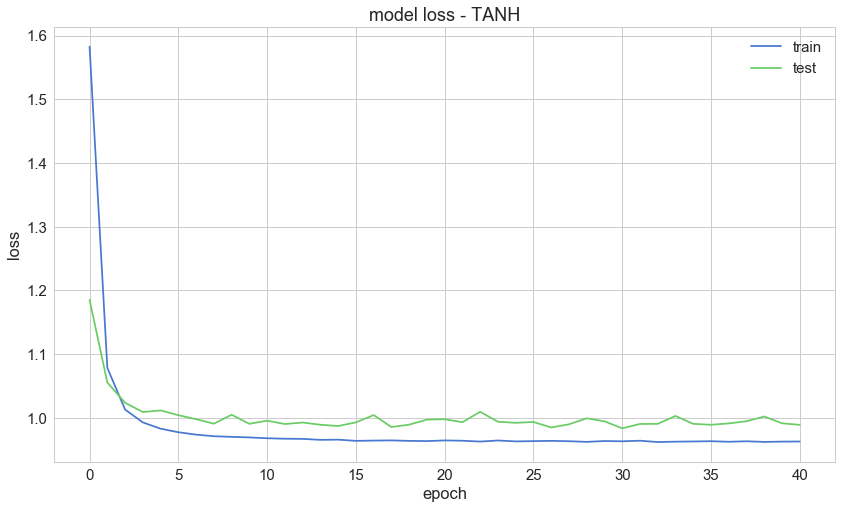

In [16]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss - TANH')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [44]:
from keras.models import load_model
model = load_model('E:\\Anomaly Detection\\newModel\\model_robust_normalization_05_06_2018_V1.h5')

In [27]:
import math
from math import pi

In [28]:
### Read data, normalize it and convert into model form ###
def dataset(filepath, splitRatio = 0.2):
    data = pd.DataFrame()
    list_ = []
    for path in filepath:
        df = pd.read_csv(path, sep = '\t', header=None)
        list_.append(df)
    data = pd.concat(list_)
    data = data.reset_index(drop=True)
    data.columns = ['Time','Desired Position','Actuator X Position','Actuator Y Position','Actuator Z Position','Desired Load','Measured Load','Motor X Current','Motor Y Current','Motor Z Current','Motor X Voltage','Motor Y Voltage','Motor Z Voltage','Motor X Temperature','Motor Y Temperature','Motor Z Temperature','Nut X Temperature','Nut Y Temperature','Nut Z Temperature','Ambient Temperature']
    data = data.drop(['Time', 'Desired Position', 'Actuator X Position', 'Actuator Y Position', 'Desired Load', 'Motor Z Voltage', 'Nut Z Temperature'], axis=1)

    # Copy the original dataset
    scaled_features = data.copy()

    # Extract column names to be standardized
    col_names = data.columns.values

    # Standardize the columns and re-assingn to original dataframe
    features = scaled_features[col_names]
    scaler = RobustScaler().fit_transform(features.values)
    features = pd.DataFrame(scaler, index=data.index, columns=col_names)
    scaled_features [col_names] = features

    scaled_features = np.array(scaled_features)
    startIndex = 0
    sensorData = []
    for i in range(len(scaled_features)):
        endIndex = 50 + i
        tempData = np.array(scaled_features[startIndex : endIndex])
        tempData = np.asarray(tempData).reshape(-1)
        sensorData.append(tempData)
        startIndex += 1
        if endIndex == len(scaled_features)-1:
            break
    sensorData = pd.DataFrame(sensorData)
    X_train, X_test = train_test_split(sensorData, test_size=splitRatio, random_state=RANDOM_SEED)
    X_train = X_train.values
    return X_train, col_names

In [29]:
def cal_RMSE(predictions, X_test):
    error_df = pd.DataFrame()
    for i in range(len(predictions)):
        temp = pd.Series((predictions[i] - X_test[i])**2)
        error_df[i] = temp
    error_df = error_df.T
    return error_df

In [30]:
def convertModelDataBackToSensorData(squaredError):
    squaredError = np.array(squaredError)
    mainSensorData = []
    for i in range(len(squaredError)):
        startIndex = 0
        singleSensorData = []
        for j in range(1, int(len(squaredError[i])/13)+1):
            endIndex = 13*j
            temp = []
            for k in range(startIndex, endIndex):
                temp.append(squaredError[i][k])
            singleSensorData.append(temp)
            startIndex = endIndex
        mainSensorData.append(singleSensorData)
    return mainSensorData

In [31]:
def mean_of_sensor_rmse(sensor_rmse):
    sensor_mean = []
    for i in range(len(sensor_rmse)):
        t = pd.DataFrame(sensor_rmse[i])
        t_col = list(t)
        temp_mean = []
        for each in t_col:
            temp_mean.append(t[each].mean() / len(t[each]))
        sensor_mean.append(temp_mean)
    return sensor_mean

In [32]:
# Plots a radar chart.
def plotRadarChart(axisLabel, plotValues):
    # Set data
    cat = axisLabel
    values = plotValues
    N = len(cat)
    x_as = [n / float(N) * 2 * pi for n in range(N)]

    # Because our chart will be circular we need to append a copy of the first 
    # value of each list at the end of each list with data
    #values += values[:1]
    x_as += x_as[:1]


    # Set color of axes
    plt.rc('axes', linewidth=0.5, edgecolor="#888888")


    # Create polar plot
    ax = plt.subplot(111, polar=True)


    # Set clockwise rotation. That is:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)


    # Set position of y-labels
    ax.set_rlabel_position(0)


    # Set color and linestyle of grid
    ax.xaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
    ax.yaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)


    # Set number of radial axes and remove labels
    plt.xticks(x_as[:-1], [])

    # Set yticks
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], rotation=45)


    # Plot data
    count = 0
    for i in range(len(values)):
        #print(values[i].append(values[i+1][0])
        value = values[i]

        if i == (len(values)-1):
            value.append(values[0][0])
        else:
            value.append(values[i+1][0])

        ax.plot(x_as, value, linewidth=1, linestyle='solid', zorder=0, color = 'b')

    # Fill area
    # ax.fill(x_as, value, 'b', alpha=0.3)


    # Set axes limits
    plt.ylim(0, 1.00)


    # Draw ytick labels to make sure they fit properly
    for i in range(N):
        angle_rad = i / float(N) * 2 * pi

        if angle_rad == 0:
            ha, distance_ax = "center", 1.1
        elif 0 < angle_rad < pi:
            ha, distance_ax = "left", 1.1
        elif angle_rad == pi:
            ha, distance_ax = "center", 1.1
        else:
            ha, distance_ax = "right", 1.1

        ax.text(angle_rad, distance_ax, cat[i], size=10, horizontalalignment=ha, verticalalignment="center")

    # Show polar plot
    plt.show()

In [33]:
### Read dataset from disk
nominalPath = glob.glob(test_data_path + '*Nominal_Low.*')
jamPath = glob.glob(test_data_path + '*Jam_Low.*')
spallPath = glob.glob('*Spall_Low.*')

In [34]:
### call various methods for calculate rmse in data
nominalTestset, col_names = dataset(nominalPath, splitRatio = 0.9)
nominalPredictions = model.predict(nominalTestset)
nominalsquaredError = cal_RMSE(nominalPredictions, nominalTestset)
nominal_sensor_rmse = convertModelDataBackToSensorData(nominalsquaredError)
final_nominalsensorRMSE = mean_of_sensor_rmse(nominal_sensor_rmse)

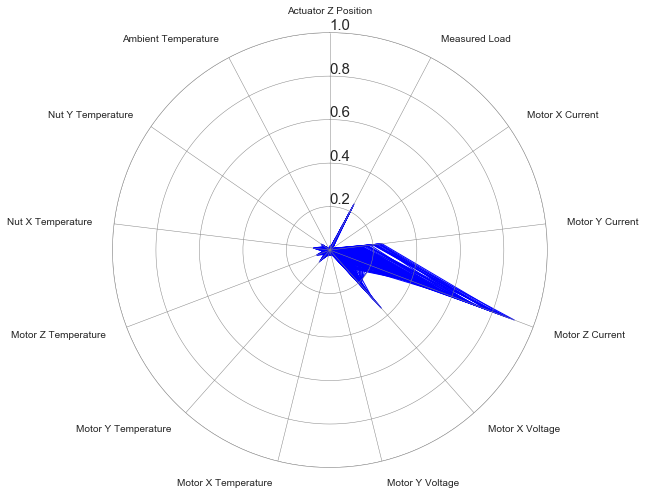

In [36]:
plotRadarChart(col_names, final_nominalsensorRMSE)

In [37]:
### call various methods for calculate rmse in data
jamTestset, col_names = dataset(jamPath, splitRatio = 0.9)
jamPredictions = model.predict(jamTestset)
jamsquaredError = cal_RMSE(jamPredictions, jamTestset)
jam_sensor_rmse = convertModelDataBackToSensorData(jamsquaredError)
final_jamsensorRMSE = mean_of_sensor_rmse(jam_sensor_rmse)

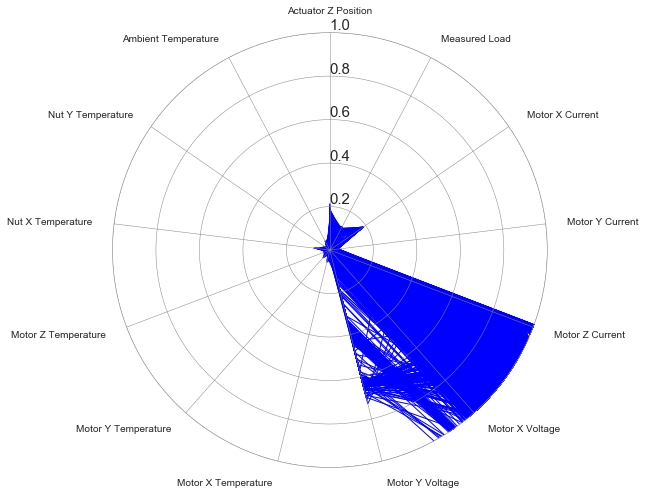

In [39]:
plotRadarChart(col_names, final_jamsensorRMSE)

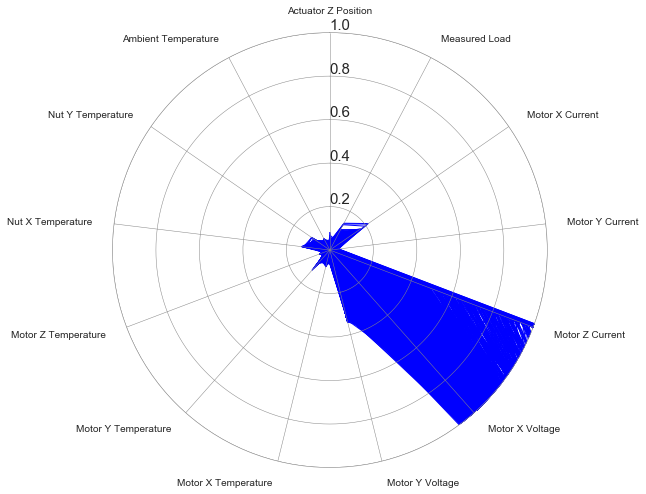

In [40]:
### call various methods for calculate rmse in data
spallTestset, col_names = dataset(spallPath, splitRatio = 0.9)
spallPredictions = model.predict(spallTestset)
spallsquaredError = cal_RMSE(spallPredictions, spallTestset)
spall_sensor_rmse = convertModelDataBackToSensorData(spallsquaredError)
final_spallsensorRMSE = mean_of_sensor_rmse(spall_sensor_rmse)
plotRadarChart(col_names, final_spallsensorRMSE)

In [41]:
final_spallsensorRMSE[0]

[0.004445946896575731,
 0.0003237190432937538,
 0.002756429311549508,
 0.011565338075646055,
 0.09013663723919602,
 0.27545309003993973,
 0.002001721063253715,
 0.0008907170984978291,
 0.032728797695815465,
 0.007152422148822413,
 0.001617892174387772,
 0.005796129036345692,
 0.0005913215993822756,
 0.0059517543820456955]